# CS5814: Assignment 2

## Problem 3

This problem involves modifying an existing encoder-decoder model designed for the COCO dataset, to use the Flickr 8k dataset. Information on the Flickr dataset can be found here: https://www.kaggle.com/datasets/adityajn105/flickr8k.

The model utilizes a pre-trained ResNet-50 model as the encoder and an LSTM as the decoder.

Data is split via a 80:10:10 train:val:test split, with the encoder-decoder model is trained for 5 epochs.

10 random images from the test set are displayed within the final cell, along with the corresponding captions generated, reference captions, and corpus BLEU values.

### Imports and config

In [100]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Supressing Jupyter Notebook torchvision installation error 

import os
import os.path
import random
import nltk
import pickle
import argparse

import nltk
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
from collections import Counter

import torch
from torchvision import transforms, datasets
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms
from nltk.translate.bleu_score import SmoothingFunction


os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


In [88]:
# Setting Random Seed
RANDOM_SEED = 3819969

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [89]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Building Vocab

All words within the Flickr8k.token.txt file are scanned to populate a vocabulary. The Vocabulary class and build_vocab functions are largely copied from the provided example code used for the COCO dataset.

In [90]:
def collate_annotations():
    # Helper function to restructure the Flickr8k.token.txt file into a list of dictionaries containting:
    # image_id (file name), caption_id (0-4), caption

    items = defaultdict(list)
    item_list = []
    pattern = re.compile(r"\t|#")
    output_dir = 'Q3_data/flickr_data/annotations.pkl'

    with open('Q3_data/flickr_data/Flickr8k_text/Flickr8k.token.txt') as f:
        items = defaultdict(list)

        for line in f:
            line = line.strip("\n")
            line = pattern.split(line)
            image_id, caption_id, caption = line[0], line[1], line[2]
            item_list.append({"image_id":image_id, "caption_id":caption_id, "caption":caption})

    with open('Q3_data/flickr_data/annotations.pkl', 'wb') as fp:
        pickle.dump(item_list, fp)
        print("Saved annotations.pkl in {}".format(output_dir))
        
collate_annotations()

Saved annotations.pkl in Q3_data/flickr_data/annotations.pkl


In [7]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

def build_vocab(txt, threshold):
    """Build a simple vocabulary wrapper."""

    with open('Q3_data/flickr_data/Flickr8k_text/Flickr8k.token.txt') as f:
        flikr = {}
        for line in f:
            line = line.strip("\n").split("\t")
            key, value = line[0], line[1]
            flikr[key] = value

    counter = Counter()
    ids = flikr.keys()

    for i, id in enumerate(ids):
        caption = str(flikr[id])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i+1) % 5000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

In [9]:
caption_path = 'Q3_data/flickr_data/Flickr8k_text/Flickr8k.token.txt'
vocab_path = 'Q3_data/flickr_data/vocab.pkl'
threshold = 4
vocab = build_vocab(txt=caption_path, threshold=threshold)

print("Total vocabulary size: {}".format(len(vocab)))
print("Saved the vocabulary wrapper to '{}'".format(vocab_path))

[1000/40455] Tokenized the captions.
[2000/40455] Tokenized the captions.
[3000/40455] Tokenized the captions.
[4000/40455] Tokenized the captions.
[5000/40455] Tokenized the captions.
[6000/40455] Tokenized the captions.
[7000/40455] Tokenized the captions.
[8000/40455] Tokenized the captions.
[9000/40455] Tokenized the captions.
[10000/40455] Tokenized the captions.
[11000/40455] Tokenized the captions.
[12000/40455] Tokenized the captions.
[13000/40455] Tokenized the captions.
[14000/40455] Tokenized the captions.
[15000/40455] Tokenized the captions.
[16000/40455] Tokenized the captions.
[17000/40455] Tokenized the captions.
[18000/40455] Tokenized the captions.
[19000/40455] Tokenized the captions.
[20000/40455] Tokenized the captions.
[21000/40455] Tokenized the captions.
[22000/40455] Tokenized the captions.
[23000/40455] Tokenized the captions.
[24000/40455] Tokenized the captions.
[25000/40455] Tokenized the captions.
[26000/40455] Tokenized the captions.
[27000/40455] Tokeniz

## Resizing the images

Images are resized to a constant 256x256, the below functions are slight modifications from the example code used for the COCO dataset.

In [18]:
def resize_image(image, size):
    """Resize an image to the given size."""
    return image.resize(size, Image.ANTIALIAS)

def resize_images(image_dir, output_dir, size):
    """Resize the images in 'image_dir' and save into 'output_dir'."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = os.listdir(image_dir)
    num_images = len(images)
    for i, image in enumerate(images):
        with open(os.path.join(image_dir, image), 'r+b') as f:
            with Image.open(f) as img:
                img = resize_image(img, size)
                img.save(os.path.join(output_dir, image), img.format)
        if (i+1) % 1000 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'."
                   .format(i+1, num_images, output_dir))


image_dir = 'Q3_data/flickr_data/Flickr8k_Dataset/Flicker8k_Dataset/'
output_dir = 'Q3_data/flickr_data/resized_jupyter/'
image_size_axis = 256
image_size = [image_size_axis, image_size_axis]
resize_images(image_dir, output_dir, image_size)

[1000/8091] Resized the images and saved into 'Q3_data/flickr_data/resized_jupyter/'.
[2000/8091] Resized the images and saved into 'Q3_data/flickr_data/resized_jupyter/'.
[3000/8091] Resized the images and saved into 'Q3_data/flickr_data/resized_jupyter/'.
[4000/8091] Resized the images and saved into 'Q3_data/flickr_data/resized_jupyter/'.
[5000/8091] Resized the images and saved into 'Q3_data/flickr_data/resized_jupyter/'.
[6000/8091] Resized the images and saved into 'Q3_data/flickr_data/resized_jupyter/'.
[7000/8091] Resized the images and saved into 'Q3_data/flickr_data/resized_jupyter/'.
[8000/8091] Resized the images and saved into 'Q3_data/flickr_data/resized_jupyter/'.


## Flikr Data Loader

Custom Data Loaders are implemented to efficently iterated through the dataset during training and validation. Code is modified from the COCO dataset example code.

The get loader function is expanded upon such that the shuffle indices are saved, allowing for efficent reloading of particular data partions on subsequent instances.


In [3]:
class FlickrDataset(data.Dataset):
    """Flickr Custom Dataset compatible with torch.utils.data.DataLoader."""

    def __init__(self, root, json_dir, vocab, transform=None):
        """Set the path for images, captions and vocabulary wrapper.

        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        
        self.root = root

        with open(json_dir, "rb") as f:
            self.captions = pickle.load(f)

        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        captions = self.captions
        vocab = self.vocab

        caption = captions[index]['caption']
        path = captions[index]['image_id']

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.captions)


def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.

    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.

    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths


def get_loader(root, json, vocab, transform, batch_size, shuffle, num_workers, resample=False):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # flickr caption dataset
    flickr = FlickrDataset(root=root,
                           json_dir=json,
                           vocab=vocab,
                           transform=transform)

    torch.manual_seed(381996)
    if not os.path.isfile("shuffle_ids.pt") and not resample:
        random_shuffle = torch.randperm(len(flickr))
        torch.save(random_shuffle, "shuffle_ids.pt")
        print('Saved new split ids')
    else:
        random_shuffle = torch.load("shuffle_ids.pt")
        print('Loaded split ids')

    train = torch.utils.data.Subset(flickr, random_shuffle[0:int(0.8 * len(flickr))])
    val = torch.utils.data.Subset(flickr, random_shuffle[int(0.8 * len(flickr)):int(0.9 * len(flickr))])
    test = torch.utils.data.Subset(flickr, random_shuffle[int(0.9 * len(flickr)):])

    # Data loader for flickr dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).

    train_data_loader = torch.utils.data.DataLoader(dataset=train,
                                                    batch_size=batch_size,
                                                    shuffle=shuffle,
                                                    collate_fn=collate_fn)

    val_data_loader = torch.utils.data.DataLoader(dataset=val,
                                                  batch_size=batch_size,
                                                  shuffle=shuffle,
                                                  collate_fn=collate_fn)

    test_data_loader = torch.utils.data.DataLoader(dataset=test,
                                                   batch_size=10,
                                                   shuffle=False,
                                                   collate_fn=collate_fn)

    data_loaders = (train_data_loader, val_data_loader, test_data_loader)
    datasets = (train, val, test)

    return data_loaders, datasets

## Model Definitions

Code is modified from the COCO dataset example code.

In [4]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-50 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

## Training

Training is conducted with a batch size of 64 for 5 epochs. Code is modified from the COCO dataset example code and expanded upon to include periodic validation against the validation dataset, along with saving of checkpoints.

In [92]:
def training_loop():
    # Create model directory
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    # Image preprocessing, normalization for the pretrained resnet
    transform = transforms.Compose([
        transforms.RandomCrop(crop_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    # Load vocabulary wrapper
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    # Split ratios (80, 10, 10) are hard coded into the get_loaded (could be improved upon and passed in)
    data_loaders, datasets = get_loader(image_dir, caption_path, vocab,
                                        transform, batch_size,
                                        shuffle=True, num_workers=num_workers)
    
    # Unpacking data loaders and data sets
    train_data_loader, val_data_loader, test_data_loader = data_loaders
    train, val, test = datasets

    # Build the models
    encoder = EncoderCNN(embed_size).to(device)
    decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)
    decoder.train()
    encoder.train()

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
    optimizer = torch.optim.Adam(params, lr=learning_rate)
    
    # Train the models
    total_step = len(train_data_loader)
    
    for epoch in range(num_epochs):
        for i, (images, captions, lengths) in enumerate(train_data_loader):

            # Set mini-batch dataset and cast to GPU
            images = images.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

            # Forward, backward and optimize
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
            decoder.zero_grad()
            encoder.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Generate info for training step and save to log_training_output.txt
            log_training_output = 'Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'.format(
            epoch, num_epochs, i, total_step, loss.item(), np.exp(loss.item()))
            with open(os.path.join(model_path, 'log_data_training.txt'), 'a+') as log_train_file:
                log_train_file.write(log_training_output)
                log_train_file.write("\n")
                print(log_training_output)
            
            # Validation:
            if i % val_step == 0:
                # Switch to eval mode
                decoder.eval()
                encoder.eval()
                
                val_loss_array = []  # array for collating minibatch validation loss
                for j, (images, captions, lengths) in enumerate(tqdm(val_data_loader)):

                    # Set mini-batch dataset
                    images = images.to(device)
                    captions = captions.to(device)
                    targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

                    # Forward
                    features = encoder(images)
                    outputs = decoder(features, captions, lengths)
                    val_loss = criterion(outputs, targets).item()
                    val_loss_array.append(val_loss)
                
                # Collating validation log data, printing and saving to log_data.txt
                avg_val_loss = np.mean(val_loss_array)
                log_output = 'Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}, Val Loss: {:.4f}, Val Perplexity: {:5.4f}'.format(
                    epoch, num_epochs, i, total_step, loss.item(), np.exp(loss.item()),
                    avg_val_loss, np.exp(avg_val_loss))

                with open(os.path.join(model_path, 'log_data.txt'), 'a+') as log_file:
                    log_file.write(log_output)
                    log_file.write("\n")

                print(log_output)
    
                # Moving back to training mode
                decoder.train()
                encoder.train()

            # Save the model checkpoints
            if (i + 1) % save_step == 0:
                print("Saving checkpoint")
                torch.save(decoder.state_dict(), os.path.join(
                    model_path, 'decoder-{}-{}.ckpt'.format(epoch + 1, i + 1)))
                torch.save(encoder.state_dict(), os.path.join(
                    model_path, 'encoder-{}-{}.ckpt'.format(epoch + 1, i + 1)))


                
# Training paramaters (these have been taken from the ArgumentParser, which was threw errors in a JupyerNotebook)
                
model_path='Q3_data/jupyter_redo/'                     # path for saving trained models
crop_size = 224                                        # size for randomly cropping images
vocab_path ='Q3_data/flickr_data/vocab.pkl'            # path for vocabulary wrapper
image_dir ='Q3_data/flickr_data/resized'               # directory for resized images
caption_path ='Q3_data/flickr_data/annotations.pkl'    # path for train annotation json file
val_step=50                                            # step size for prining log info
save_step=100                                          # step size for saving trained models

# Model parameters
embed_size=256                                         # dimension of word embedding vectors
hidden_size=512                                        # dimension of lstm hidden states
num_layers=1                                           # number of layers in lstm
num_epochs=5
batch_size=64
num_workers=2
learning_rate=0.001

training_loop()


Loaded split ids
Epoch [0/5], Step [0/506], Loss: 8.1525, Perplexity: 3472.0290


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:36<00:00,  1.74it/s]


Epoch [0/5], Step [0/506], Loss: 8.1525, Perplexity: 3472.0290, Val Loss: 8.0592, Val Perplexity: 3162.8867
Epoch [0/5], Step [1/506], Loss: 8.0638, Perplexity: 3177.4801
Epoch [0/5], Step [2/506], Loss: 7.9545, Perplexity: 2848.3521
Epoch [0/5], Step [3/506], Loss: 7.8264, Perplexity: 2505.8866
Epoch [0/5], Step [4/506], Loss: 7.6545, Perplexity: 2110.0645
Epoch [0/5], Step [5/506], Loss: 7.3777, Perplexity: 1599.8994
Epoch [0/5], Step [6/506], Loss: 6.8937, Perplexity: 986.0493
Epoch [0/5], Step [7/506], Loss: 6.3272, Perplexity: 559.5600
Epoch [0/5], Step [8/506], Loss: 5.8550, Perplexity: 348.9598
Epoch [0/5], Step [9/506], Loss: 5.5795, Perplexity: 264.9421
Epoch [0/5], Step [10/506], Loss: 5.1880, Perplexity: 179.1104
Epoch [0/5], Step [11/506], Loss: 5.4231, Perplexity: 226.5710
Epoch [0/5], Step [12/506], Loss: 5.1504, Perplexity: 172.5045
Epoch [0/5], Step [13/506], Loss: 5.3615, Perplexity: 213.0402
Epoch [0/5], Step [14/506], Loss: 5.3238, Perplexity: 205.1565
Epoch [0/5], S

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:40<00:00,  1.57it/s]


Epoch [0/5], Step [50/506], Loss: 3.8741, Perplexity: 48.1396, Val Loss: 3.9738, Val Perplexity: 53.1861
Epoch [0/5], Step [51/506], Loss: 3.8319, Perplexity: 46.1479
Epoch [0/5], Step [52/506], Loss: 3.8577, Perplexity: 47.3545
Epoch [0/5], Step [53/506], Loss: 3.9835, Perplexity: 53.7041
Epoch [0/5], Step [54/506], Loss: 3.9936, Perplexity: 54.2496
Epoch [0/5], Step [55/506], Loss: 3.9301, Perplexity: 50.9141
Epoch [0/5], Step [56/506], Loss: 3.7486, Perplexity: 42.4603
Epoch [0/5], Step [57/506], Loss: 3.9268, Perplexity: 50.7424
Epoch [0/5], Step [58/506], Loss: 4.0175, Perplexity: 55.5604
Epoch [0/5], Step [59/506], Loss: 3.8229, Perplexity: 45.7386
Epoch [0/5], Step [60/506], Loss: 3.7550, Perplexity: 42.7347
Epoch [0/5], Step [61/506], Loss: 3.8611, Perplexity: 47.5164
Epoch [0/5], Step [62/506], Loss: 3.7307, Perplexity: 41.7086
Epoch [0/5], Step [63/506], Loss: 3.8405, Perplexity: 46.5493
Epoch [0/5], Step [64/506], Loss: 3.6145, Perplexity: 37.1344
Epoch [0/5], Step [65/506],

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:41<00:00,  1.54it/s]


Epoch [0/5], Step [100/506], Loss: 3.5629, Perplexity: 35.2666, Val Loss: 3.5162, Val Perplexity: 33.6565
Epoch [0/5], Step [101/506], Loss: 3.4848, Perplexity: 32.6171
Epoch [0/5], Step [102/506], Loss: 3.5600, Perplexity: 35.1614
Epoch [0/5], Step [103/506], Loss: 3.4484, Perplexity: 31.4490
Epoch [0/5], Step [104/506], Loss: 3.4391, Perplexity: 31.1587
Epoch [0/5], Step [105/506], Loss: 3.5028, Perplexity: 33.2072
Epoch [0/5], Step [106/506], Loss: 3.4521, Perplexity: 31.5652
Epoch [0/5], Step [107/506], Loss: 3.5488, Perplexity: 34.7703
Epoch [0/5], Step [108/506], Loss: 3.5585, Perplexity: 35.1091
Epoch [0/5], Step [109/506], Loss: 3.4703, Perplexity: 32.1473
Epoch [0/5], Step [110/506], Loss: 3.6269, Perplexity: 37.5954
Epoch [0/5], Step [111/506], Loss: 3.4224, Perplexity: 30.6444
Epoch [0/5], Step [112/506], Loss: 3.6274, Perplexity: 37.6165
Epoch [0/5], Step [113/506], Loss: 3.4408, Perplexity: 31.2104
Epoch [0/5], Step [114/506], Loss: 3.4897, Perplexity: 32.7749
Epoch [0/5],

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:38<00:00,  1.65it/s]


Epoch [0/5], Step [150/506], Loss: 3.2976, Perplexity: 27.0479, Val Loss: 3.3152, Val Perplexity: 27.5280
Epoch [0/5], Step [151/506], Loss: 3.2105, Perplexity: 24.7911
Epoch [0/5], Step [152/506], Loss: 3.2967, Perplexity: 27.0241
Epoch [0/5], Step [153/506], Loss: 3.2883, Perplexity: 26.7975
Epoch [0/5], Step [154/506], Loss: 3.2624, Perplexity: 26.1132
Epoch [0/5], Step [155/506], Loss: 3.2602, Perplexity: 26.0541
Epoch [0/5], Step [156/506], Loss: 3.1820, Perplexity: 24.0956
Epoch [0/5], Step [157/506], Loss: 3.3305, Perplexity: 27.9519
Epoch [0/5], Step [158/506], Loss: 3.3938, Perplexity: 29.7792
Epoch [0/5], Step [159/506], Loss: 3.2639, Perplexity: 26.1523
Epoch [0/5], Step [160/506], Loss: 3.2495, Perplexity: 25.7771
Epoch [0/5], Step [161/506], Loss: 3.3084, Perplexity: 27.3411
Epoch [0/5], Step [162/506], Loss: 3.3465, Perplexity: 28.4030
Epoch [0/5], Step [163/506], Loss: 3.2733, Perplexity: 26.3992
Epoch [0/5], Step [164/506], Loss: 3.3172, Perplexity: 27.5818
Epoch [0/5],

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:40<00:00,  1.59it/s]


Epoch [0/5], Step [200/506], Loss: 3.2811, Perplexity: 26.6044, Val Loss: 3.1786, Val Perplexity: 24.0136
Epoch [0/5], Step [201/506], Loss: 3.4390, Perplexity: 31.1559
Epoch [0/5], Step [202/506], Loss: 3.1437, Perplexity: 23.1905
Epoch [0/5], Step [203/506], Loss: 3.3761, Perplexity: 29.2573
Epoch [0/5], Step [204/506], Loss: 3.2663, Perplexity: 26.2139
Epoch [0/5], Step [205/506], Loss: 3.2384, Perplexity: 25.4936
Epoch [0/5], Step [206/506], Loss: 3.2226, Perplexity: 25.0930
Epoch [0/5], Step [207/506], Loss: 3.1826, Perplexity: 24.1095
Epoch [0/5], Step [208/506], Loss: 3.2309, Perplexity: 25.3029
Epoch [0/5], Step [209/506], Loss: 3.1360, Perplexity: 23.0105
Epoch [0/5], Step [210/506], Loss: 3.0520, Perplexity: 21.1580
Epoch [0/5], Step [211/506], Loss: 3.0712, Perplexity: 21.5682
Epoch [0/5], Step [212/506], Loss: 3.2483, Perplexity: 25.7458
Epoch [0/5], Step [213/506], Loss: 3.0967, Perplexity: 22.1240
Epoch [0/5], Step [214/506], Loss: 3.2975, Perplexity: 27.0463
Epoch [0/5],

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:39<00:00,  1.61it/s]


Epoch [0/5], Step [250/506], Loss: 3.1400, Perplexity: 23.1036, Val Loss: 3.0919, Val Perplexity: 22.0198
Epoch [0/5], Step [251/506], Loss: 3.1140, Perplexity: 22.5116
Epoch [0/5], Step [252/506], Loss: 2.9504, Perplexity: 19.1140
Epoch [0/5], Step [253/506], Loss: 2.9659, Perplexity: 19.4128
Epoch [0/5], Step [254/506], Loss: 3.1504, Perplexity: 23.3462
Epoch [0/5], Step [255/506], Loss: 3.0521, Perplexity: 21.1601
Epoch [0/5], Step [256/506], Loss: 3.1023, Perplexity: 22.2488
Epoch [0/5], Step [257/506], Loss: 3.2164, Perplexity: 24.9392
Epoch [0/5], Step [258/506], Loss: 2.8151, Perplexity: 16.6941
Epoch [0/5], Step [259/506], Loss: 3.1065, Perplexity: 22.3429
Epoch [0/5], Step [260/506], Loss: 3.0169, Perplexity: 20.4277
Epoch [0/5], Step [261/506], Loss: 2.9947, Perplexity: 19.9800
Epoch [0/5], Step [262/506], Loss: 3.2640, Perplexity: 26.1532
Epoch [0/5], Step [263/506], Loss: 3.0865, Perplexity: 21.8995
Epoch [0/5], Step [264/506], Loss: 3.1283, Perplexity: 22.8343
Epoch [0/5],

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:40<00:00,  1.59it/s]


Epoch [0/5], Step [300/506], Loss: 3.0098, Perplexity: 20.2828, Val Loss: 3.0113, Val Perplexity: 20.3142
Epoch [0/5], Step [301/506], Loss: 3.0165, Perplexity: 20.4191
Epoch [0/5], Step [302/506], Loss: 3.1524, Perplexity: 23.3933
Epoch [0/5], Step [303/506], Loss: 3.1523, Perplexity: 23.3898
Epoch [0/5], Step [304/506], Loss: 3.0990, Perplexity: 22.1754
Epoch [0/5], Step [305/506], Loss: 3.0206, Perplexity: 20.5030
Epoch [0/5], Step [306/506], Loss: 3.0689, Perplexity: 21.5173
Epoch [0/5], Step [307/506], Loss: 3.0282, Perplexity: 20.6607
Epoch [0/5], Step [308/506], Loss: 3.1127, Perplexity: 22.4806
Epoch [0/5], Step [309/506], Loss: 3.1516, Perplexity: 23.3728
Epoch [0/5], Step [310/506], Loss: 3.0062, Perplexity: 20.2108
Epoch [0/5], Step [311/506], Loss: 2.9738, Perplexity: 19.5654
Epoch [0/5], Step [312/506], Loss: 2.8611, Perplexity: 17.4807
Epoch [0/5], Step [313/506], Loss: 3.0221, Perplexity: 20.5350
Epoch [0/5], Step [314/506], Loss: 2.9580, Perplexity: 19.2603
Epoch [0/5],

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:38<00:00,  1.65it/s]


Epoch [0/5], Step [350/506], Loss: 2.8795, Perplexity: 17.8057, Val Loss: 2.9560, Val Perplexity: 19.2207
Epoch [0/5], Step [351/506], Loss: 2.8531, Perplexity: 17.3411
Epoch [0/5], Step [352/506], Loss: 2.9633, Perplexity: 19.3618
Epoch [0/5], Step [353/506], Loss: 3.0326, Perplexity: 20.7521
Epoch [0/5], Step [354/506], Loss: 3.0280, Perplexity: 20.6569
Epoch [0/5], Step [355/506], Loss: 3.2379, Perplexity: 25.4800
Epoch [0/5], Step [356/506], Loss: 2.9720, Perplexity: 19.5309
Epoch [0/5], Step [357/506], Loss: 2.9192, Perplexity: 18.5272
Epoch [0/5], Step [358/506], Loss: 3.0926, Perplexity: 22.0339
Epoch [0/5], Step [359/506], Loss: 3.0719, Perplexity: 21.5824
Epoch [0/5], Step [360/506], Loss: 3.0448, Perplexity: 21.0062
Epoch [0/5], Step [361/506], Loss: 2.9472, Perplexity: 19.0532
Epoch [0/5], Step [362/506], Loss: 3.0324, Perplexity: 20.7470
Epoch [0/5], Step [363/506], Loss: 2.8044, Perplexity: 16.5164
Epoch [0/5], Step [364/506], Loss: 2.8252, Perplexity: 16.8642
Epoch [0/5],

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:39<00:00,  1.64it/s]


Epoch [0/5], Step [400/506], Loss: 2.9064, Perplexity: 18.2906, Val Loss: 2.8967, Val Perplexity: 18.1141
Epoch [0/5], Step [401/506], Loss: 2.9880, Perplexity: 19.8465
Epoch [0/5], Step [402/506], Loss: 2.8629, Perplexity: 17.5117
Epoch [0/5], Step [403/506], Loss: 2.9039, Perplexity: 18.2459
Epoch [0/5], Step [404/506], Loss: 3.0363, Perplexity: 20.8284
Epoch [0/5], Step [405/506], Loss: 2.8248, Perplexity: 16.8571
Epoch [0/5], Step [406/506], Loss: 2.9765, Perplexity: 19.6187
Epoch [0/5], Step [407/506], Loss: 2.9770, Perplexity: 19.6285
Epoch [0/5], Step [408/506], Loss: 2.8602, Perplexity: 17.4655
Epoch [0/5], Step [409/506], Loss: 2.8225, Perplexity: 16.8193
Epoch [0/5], Step [410/506], Loss: 2.7825, Perplexity: 16.1599
Epoch [0/5], Step [411/506], Loss: 2.8913, Perplexity: 18.0173
Epoch [0/5], Step [412/506], Loss: 2.8616, Perplexity: 17.4892
Epoch [0/5], Step [413/506], Loss: 2.8306, Perplexity: 16.9561
Epoch [0/5], Step [414/506], Loss: 2.7826, Perplexity: 16.1617
Epoch [0/5],

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:38<00:00,  1.64it/s]


Epoch [0/5], Step [450/506], Loss: 2.9554, Perplexity: 19.2103, Val Loss: 2.8455, Val Perplexity: 17.2100
Epoch [0/5], Step [451/506], Loss: 2.7280, Perplexity: 15.3027
Epoch [0/5], Step [452/506], Loss: 2.9988, Perplexity: 20.0615
Epoch [0/5], Step [453/506], Loss: 2.8658, Perplexity: 17.5634
Epoch [0/5], Step [454/506], Loss: 2.6871, Perplexity: 14.6892
Epoch [0/5], Step [455/506], Loss: 2.8117, Perplexity: 16.6381
Epoch [0/5], Step [456/506], Loss: 2.7243, Perplexity: 15.2458
Epoch [0/5], Step [457/506], Loss: 2.9157, Perplexity: 18.4609
Epoch [0/5], Step [458/506], Loss: 2.9281, Perplexity: 18.6923
Epoch [0/5], Step [459/506], Loss: 2.7589, Perplexity: 15.7826
Epoch [0/5], Step [460/506], Loss: 2.8347, Perplexity: 17.0248
Epoch [0/5], Step [461/506], Loss: 2.7897, Perplexity: 16.2760
Epoch [0/5], Step [462/506], Loss: 2.8077, Perplexity: 16.5725
Epoch [0/5], Step [463/506], Loss: 2.8230, Perplexity: 16.8276
Epoch [0/5], Step [464/506], Loss: 2.8396, Perplexity: 17.1082
Epoch [0/5],

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:38<00:00,  1.64it/s]


Epoch [0/5], Step [500/506], Loss: 2.9645, Perplexity: 19.3856, Val Loss: 2.8031, Val Perplexity: 16.4964
Epoch [0/5], Step [501/506], Loss: 2.7103, Perplexity: 15.0343
Epoch [0/5], Step [502/506], Loss: 2.9439, Perplexity: 18.9901
Epoch [0/5], Step [503/506], Loss: 2.7265, Perplexity: 15.2787
Epoch [0/5], Step [504/506], Loss: 2.8566, Perplexity: 17.4031
Epoch [0/5], Step [505/506], Loss: 2.7413, Perplexity: 15.5067
Epoch [1/5], Step [0/506], Loss: 2.6301, Perplexity: 13.8750


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:39<00:00,  1.64it/s]


Epoch [1/5], Step [0/506], Loss: 2.6301, Perplexity: 13.8750, Val Loss: 2.8055, Val Perplexity: 16.5346
Epoch [1/5], Step [1/506], Loss: 2.5717, Perplexity: 13.0885
Epoch [1/5], Step [2/506], Loss: 2.8916, Perplexity: 18.0217
Epoch [1/5], Step [3/506], Loss: 2.7806, Perplexity: 16.1288
Epoch [1/5], Step [4/506], Loss: 2.7434, Perplexity: 15.5398
Epoch [1/5], Step [5/506], Loss: 2.8128, Perplexity: 16.6569
Epoch [1/5], Step [6/506], Loss: 2.9247, Perplexity: 18.6292
Epoch [1/5], Step [7/506], Loss: 2.6458, Perplexity: 14.0953
Epoch [1/5], Step [8/506], Loss: 2.7664, Perplexity: 15.9008
Epoch [1/5], Step [9/506], Loss: 2.5493, Perplexity: 12.7976
Epoch [1/5], Step [10/506], Loss: 2.6545, Perplexity: 14.2175
Epoch [1/5], Step [11/506], Loss: 2.5829, Perplexity: 13.2361
Epoch [1/5], Step [12/506], Loss: 2.9403, Perplexity: 18.9223
Epoch [1/5], Step [13/506], Loss: 2.6387, Perplexity: 13.9949
Epoch [1/5], Step [14/506], Loss: 2.6030, Perplexity: 13.5042
Epoch [1/5], Step [15/506], Loss: 2.6

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:39<00:00,  1.61it/s]


Epoch [1/5], Step [50/506], Loss: 2.4249, Perplexity: 11.3013, Val Loss: 2.7679, Val Perplexity: 15.9257
Epoch [1/5], Step [51/506], Loss: 2.6881, Perplexity: 14.7031
Epoch [1/5], Step [52/506], Loss: 2.8839, Perplexity: 17.8845
Epoch [1/5], Step [53/506], Loss: 2.6312, Perplexity: 13.8902
Epoch [1/5], Step [54/506], Loss: 2.5498, Perplexity: 12.8046
Epoch [1/5], Step [55/506], Loss: 2.6585, Perplexity: 14.2755
Epoch [1/5], Step [56/506], Loss: 2.6325, Perplexity: 13.9080
Epoch [1/5], Step [57/506], Loss: 2.6874, Perplexity: 14.6936
Epoch [1/5], Step [58/506], Loss: 2.7302, Perplexity: 15.3366
Epoch [1/5], Step [59/506], Loss: 2.8879, Perplexity: 17.9563
Epoch [1/5], Step [60/506], Loss: 2.5470, Perplexity: 12.7689
Epoch [1/5], Step [61/506], Loss: 2.6849, Perplexity: 14.6570
Epoch [1/5], Step [62/506], Loss: 2.8948, Perplexity: 18.0805
Epoch [1/5], Step [63/506], Loss: 2.7021, Perplexity: 14.9116
Epoch [1/5], Step [64/506], Loss: 2.7375, Perplexity: 15.4476
Epoch [1/5], Step [65/506],

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:43<00:00,  1.47it/s]


Epoch [1/5], Step [100/506], Loss: 2.6610, Perplexity: 14.3113, Val Loss: 2.7270, Val Perplexity: 15.2873
Epoch [1/5], Step [101/506], Loss: 2.6055, Perplexity: 13.5377
Epoch [1/5], Step [102/506], Loss: 2.6798, Perplexity: 14.5815
Epoch [1/5], Step [103/506], Loss: 2.7156, Perplexity: 15.1142
Epoch [1/5], Step [104/506], Loss: 2.6960, Perplexity: 14.8198
Epoch [1/5], Step [105/506], Loss: 2.6228, Perplexity: 13.7740
Epoch [1/5], Step [106/506], Loss: 2.6880, Perplexity: 14.7028
Epoch [1/5], Step [107/506], Loss: 2.9332, Perplexity: 18.7880
Epoch [1/5], Step [108/506], Loss: 2.6415, Perplexity: 14.0338
Epoch [1/5], Step [109/506], Loss: 2.6151, Perplexity: 13.6683
Epoch [1/5], Step [110/506], Loss: 2.8426, Perplexity: 17.1599
Epoch [1/5], Step [111/506], Loss: 2.6727, Perplexity: 14.4789
Epoch [1/5], Step [112/506], Loss: 2.7985, Perplexity: 16.4193
Epoch [1/5], Step [113/506], Loss: 2.6946, Perplexity: 14.7994
Epoch [1/5], Step [114/506], Loss: 2.6997, Perplexity: 14.8750
Epoch [1/5],

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:38<00:00,  1.65it/s]


Epoch [1/5], Step [150/506], Loss: 2.6427, Perplexity: 14.0509, Val Loss: 2.7087, Val Perplexity: 15.0099
Epoch [1/5], Step [151/506], Loss: 2.7059, Perplexity: 14.9675
Epoch [1/5], Step [152/506], Loss: 2.6906, Perplexity: 14.7409
Epoch [1/5], Step [153/506], Loss: 2.7657, Perplexity: 15.8906
Epoch [1/5], Step [154/506], Loss: 2.5751, Perplexity: 13.1324
Epoch [1/5], Step [155/506], Loss: 2.6418, Perplexity: 14.0389
Epoch [1/5], Step [156/506], Loss: 2.5037, Perplexity: 12.2278
Epoch [1/5], Step [157/506], Loss: 2.5711, Perplexity: 13.0798
Epoch [1/5], Step [158/506], Loss: 2.7474, Perplexity: 15.6018
Epoch [1/5], Step [159/506], Loss: 2.5457, Perplexity: 12.7522
Epoch [1/5], Step [160/506], Loss: 2.7469, Perplexity: 15.5944
Epoch [1/5], Step [161/506], Loss: 2.6436, Perplexity: 14.0631
Epoch [1/5], Step [162/506], Loss: 2.6372, Perplexity: 13.9738
Epoch [1/5], Step [163/506], Loss: 2.7669, Perplexity: 15.9093
Epoch [1/5], Step [164/506], Loss: 2.8878, Perplexity: 17.9546
Epoch [1/5],

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:38<00:00,  1.65it/s]


Epoch [1/5], Step [200/506], Loss: 2.7327, Perplexity: 15.3740, Val Loss: 2.6911, Val Perplexity: 14.7482
Epoch [1/5], Step [201/506], Loss: 2.6531, Perplexity: 14.1974
Epoch [1/5], Step [202/506], Loss: 2.6156, Perplexity: 13.6751
Epoch [1/5], Step [203/506], Loss: 2.7570, Perplexity: 15.7529
Epoch [1/5], Step [204/506], Loss: 2.6231, Perplexity: 13.7782
Epoch [1/5], Step [205/506], Loss: 2.7040, Perplexity: 14.9390
Epoch [1/5], Step [206/506], Loss: 2.4854, Perplexity: 12.0056
Epoch [1/5], Step [207/506], Loss: 2.5024, Perplexity: 12.2123
Epoch [1/5], Step [208/506], Loss: 2.6949, Perplexity: 14.8042
Epoch [1/5], Step [209/506], Loss: 2.6912, Perplexity: 14.7488
Epoch [1/5], Step [210/506], Loss: 2.6858, Perplexity: 14.6693
Epoch [1/5], Step [211/506], Loss: 2.6970, Perplexity: 14.8353
Epoch [1/5], Step [212/506], Loss: 2.7204, Perplexity: 15.1863
Epoch [1/5], Step [213/506], Loss: 2.6890, Perplexity: 14.7173
Epoch [1/5], Step [214/506], Loss: 2.6030, Perplexity: 13.5039
Epoch [1/5],

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:40<00:00,  1.59it/s]


Epoch [1/5], Step [250/506], Loss: 2.5968, Perplexity: 13.4212, Val Loss: 2.6546, Val Perplexity: 14.2200
Epoch [1/5], Step [251/506], Loss: 2.7076, Perplexity: 14.9928
Epoch [1/5], Step [252/506], Loss: 2.5964, Perplexity: 13.4155
Epoch [1/5], Step [253/506], Loss: 2.5344, Perplexity: 12.6086
Epoch [1/5], Step [254/506], Loss: 2.7326, Perplexity: 15.3728
Epoch [1/5], Step [255/506], Loss: 2.5366, Perplexity: 12.6360
Epoch [1/5], Step [256/506], Loss: 2.8552, Perplexity: 17.3772
Epoch [1/5], Step [257/506], Loss: 2.6872, Perplexity: 14.6903
Epoch [1/5], Step [258/506], Loss: 2.6172, Perplexity: 13.6976
Epoch [1/5], Step [259/506], Loss: 2.6608, Perplexity: 14.3078
Epoch [1/5], Step [260/506], Loss: 2.6728, Perplexity: 14.4800
Epoch [1/5], Step [261/506], Loss: 2.5221, Perplexity: 12.4543
Epoch [1/5], Step [262/506], Loss: 2.5312, Perplexity: 12.5686
Epoch [1/5], Step [263/506], Loss: 2.3758, Perplexity: 10.7597
Epoch [1/5], Step [264/506], Loss: 2.5187, Perplexity: 12.4128
Epoch [1/5],

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:38<00:00,  1.65it/s]


Epoch [1/5], Step [300/506], Loss: 2.6520, Perplexity: 14.1820, Val Loss: 2.6296, Val Perplexity: 13.8686
Epoch [1/5], Step [301/506], Loss: 2.6823, Perplexity: 14.6193
Epoch [1/5], Step [302/506], Loss: 2.4931, Perplexity: 12.0985
Epoch [1/5], Step [303/506], Loss: 2.5072, Perplexity: 12.2706
Epoch [1/5], Step [304/506], Loss: 2.3905, Perplexity: 10.9193
Epoch [1/5], Step [305/506], Loss: 2.5721, Perplexity: 13.0930
Epoch [1/5], Step [306/506], Loss: 2.5649, Perplexity: 12.9996
Epoch [1/5], Step [307/506], Loss: 2.7272, Perplexity: 15.2897
Epoch [1/5], Step [308/506], Loss: 2.4856, Perplexity: 12.0086
Epoch [1/5], Step [309/506], Loss: 2.4342, Perplexity: 11.4065
Epoch [1/5], Step [310/506], Loss: 2.5916, Perplexity: 13.3505
Epoch [1/5], Step [311/506], Loss: 2.6974, Perplexity: 14.8409
Epoch [1/5], Step [312/506], Loss: 2.4513, Perplexity: 11.6032
Epoch [1/5], Step [313/506], Loss: 2.5655, Perplexity: 13.0077
Epoch [1/5], Step [314/506], Loss: 2.4073, Perplexity: 11.1039
Epoch [1/5],

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:38<00:00,  1.67it/s]


Epoch [1/5], Step [350/506], Loss: 2.6784, Perplexity: 14.5621, Val Loss: 2.6067, Val Perplexity: 13.5536
Epoch [1/5], Step [351/506], Loss: 2.5447, Perplexity: 12.7397
Epoch [1/5], Step [352/506], Loss: 2.7935, Perplexity: 16.3377
Epoch [1/5], Step [353/506], Loss: 2.5582, Perplexity: 12.9121
Epoch [1/5], Step [354/506], Loss: 2.8119, Perplexity: 16.6409
Epoch [1/5], Step [355/506], Loss: 2.4747, Perplexity: 11.8780
Epoch [1/5], Step [356/506], Loss: 2.5698, Perplexity: 13.0627
Epoch [1/5], Step [357/506], Loss: 2.5067, Perplexity: 12.2650
Epoch [1/5], Step [358/506], Loss: 2.5852, Perplexity: 13.2654
Epoch [1/5], Step [359/506], Loss: 2.3560, Perplexity: 10.5486
Epoch [1/5], Step [360/506], Loss: 2.5399, Perplexity: 12.6778
Epoch [1/5], Step [361/506], Loss: 2.7599, Perplexity: 15.7984
Epoch [1/5], Step [362/506], Loss: 2.7733, Perplexity: 16.0113
Epoch [1/5], Step [363/506], Loss: 2.6505, Perplexity: 14.1605
Epoch [1/5], Step [364/506], Loss: 2.5227, Perplexity: 12.4620
Epoch [1/5],

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:38<00:00,  1.66it/s]


Epoch [1/5], Step [400/506], Loss: 2.4613, Perplexity: 11.7204, Val Loss: 2.5909, Val Perplexity: 13.3413
Epoch [1/5], Step [401/506], Loss: 2.5684, Perplexity: 13.0444
Epoch [1/5], Step [402/506], Loss: 2.4270, Perplexity: 11.3250
Epoch [1/5], Step [403/506], Loss: 2.4425, Perplexity: 11.5021
Epoch [1/5], Step [404/506], Loss: 2.5947, Perplexity: 13.3919
Epoch [1/5], Step [405/506], Loss: 2.3689, Perplexity: 10.6853
Epoch [1/5], Step [406/506], Loss: 2.4503, Perplexity: 11.5923
Epoch [1/5], Step [407/506], Loss: 2.6648, Perplexity: 14.3647
Epoch [1/5], Step [408/506], Loss: 2.6375, Perplexity: 13.9779
Epoch [1/5], Step [409/506], Loss: 2.5109, Perplexity: 12.3157
Epoch [1/5], Step [410/506], Loss: 2.5244, Perplexity: 12.4831
Epoch [1/5], Step [411/506], Loss: 2.4378, Perplexity: 11.4474
Epoch [1/5], Step [412/506], Loss: 2.5576, Perplexity: 12.9053
Epoch [1/5], Step [413/506], Loss: 2.6308, Perplexity: 13.8844
Epoch [1/5], Step [414/506], Loss: 2.6693, Perplexity: 14.4303
Epoch [1/5],

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:38<00:00,  1.65it/s]


Epoch [1/5], Step [450/506], Loss: 2.4426, Perplexity: 11.5029, Val Loss: 2.5802, Val Perplexity: 13.2002
Epoch [1/5], Step [451/506], Loss: 2.4825, Perplexity: 11.9716
Epoch [1/5], Step [452/506], Loss: 2.5248, Perplexity: 12.4880
Epoch [1/5], Step [453/506], Loss: 2.4940, Perplexity: 12.1101
Epoch [1/5], Step [454/506], Loss: 2.4003, Perplexity: 11.0260
Epoch [1/5], Step [455/506], Loss: 2.4378, Perplexity: 11.4482
Epoch [1/5], Step [456/506], Loss: 2.5405, Perplexity: 12.6864
Epoch [1/5], Step [457/506], Loss: 2.5535, Perplexity: 12.8518
Epoch [1/5], Step [458/506], Loss: 2.4225, Perplexity: 11.2735
Epoch [1/5], Step [459/506], Loss: 2.4227, Perplexity: 11.2758
Epoch [1/5], Step [460/506], Loss: 2.6055, Perplexity: 13.5376
Epoch [1/5], Step [461/506], Loss: 2.5009, Perplexity: 12.1934
Epoch [1/5], Step [462/506], Loss: 2.5003, Perplexity: 12.1857
Epoch [1/5], Step [463/506], Loss: 2.5491, Perplexity: 12.7957
Epoch [1/5], Step [464/506], Loss: 2.4138, Perplexity: 11.1765
Epoch [1/5],

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:40<00:00,  1.59it/s]


Epoch [1/5], Step [500/506], Loss: 2.5801, Perplexity: 13.1991, Val Loss: 2.5603, Val Perplexity: 12.9399
Epoch [1/5], Step [501/506], Loss: 2.4768, Perplexity: 11.9029
Epoch [1/5], Step [502/506], Loss: 2.4866, Perplexity: 12.0201
Epoch [1/5], Step [503/506], Loss: 2.5376, Perplexity: 12.6493
Epoch [1/5], Step [504/506], Loss: 2.6130, Perplexity: 13.6403
Epoch [1/5], Step [505/506], Loss: 2.6496, Perplexity: 14.1489
Epoch [2/5], Step [0/506], Loss: 2.4440, Perplexity: 11.5185


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:38<00:00,  1.65it/s]


Epoch [2/5], Step [0/506], Loss: 2.4440, Perplexity: 11.5185, Val Loss: 2.5560, Val Perplexity: 12.8842
Epoch [2/5], Step [1/506], Loss: 2.4703, Perplexity: 11.8260
Epoch [2/5], Step [2/506], Loss: 2.2895, Perplexity: 9.8702
Epoch [2/5], Step [3/506], Loss: 2.3889, Perplexity: 10.9015
Epoch [2/5], Step [4/506], Loss: 2.4119, Perplexity: 11.1554
Epoch [2/5], Step [5/506], Loss: 2.4960, Perplexity: 12.1334
Epoch [2/5], Step [6/506], Loss: 2.3841, Perplexity: 10.8488
Epoch [2/5], Step [7/506], Loss: 2.2023, Perplexity: 9.0460
Epoch [2/5], Step [8/506], Loss: 2.3210, Perplexity: 10.1859
Epoch [2/5], Step [9/506], Loss: 2.4654, Perplexity: 11.7683
Epoch [2/5], Step [10/506], Loss: 2.5144, Perplexity: 12.3586
Epoch [2/5], Step [11/506], Loss: 2.4629, Perplexity: 11.7383
Epoch [2/5], Step [12/506], Loss: 2.3389, Perplexity: 10.3693
Epoch [2/5], Step [13/506], Loss: 2.2817, Perplexity: 9.7934
Epoch [2/5], Step [14/506], Loss: 2.3264, Perplexity: 10.2406
Epoch [2/5], Step [15/506], Loss: 2.3977

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:39<00:00,  1.61it/s]


Epoch [2/5], Step [50/506], Loss: 2.3785, Perplexity: 10.7892, Val Loss: 2.5488, Val Perplexity: 12.7912
Epoch [2/5], Step [51/506], Loss: 2.5161, Perplexity: 12.3796
Epoch [2/5], Step [52/506], Loss: 2.2869, Perplexity: 9.8448
Epoch [2/5], Step [53/506], Loss: 2.2733, Perplexity: 9.7110
Epoch [2/5], Step [54/506], Loss: 2.4296, Perplexity: 11.3543
Epoch [2/5], Step [55/506], Loss: 2.5188, Perplexity: 12.4140
Epoch [2/5], Step [56/506], Loss: 2.3755, Perplexity: 10.7564
Epoch [2/5], Step [57/506], Loss: 2.4380, Perplexity: 11.4500
Epoch [2/5], Step [58/506], Loss: 2.4224, Perplexity: 11.2728
Epoch [2/5], Step [59/506], Loss: 2.3084, Perplexity: 10.0584
Epoch [2/5], Step [60/506], Loss: 2.2717, Perplexity: 9.6960
Epoch [2/5], Step [61/506], Loss: 2.2733, Perplexity: 9.7113
Epoch [2/5], Step [62/506], Loss: 2.5754, Perplexity: 13.1366
Epoch [2/5], Step [63/506], Loss: 2.4708, Perplexity: 11.8324
Epoch [2/5], Step [64/506], Loss: 2.2706, Perplexity: 9.6851
Epoch [2/5], Step [65/506], Loss

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:39<00:00,  1.62it/s]


Epoch [2/5], Step [100/506], Loss: 2.2619, Perplexity: 9.6013, Val Loss: 2.5371, Val Perplexity: 12.6426
Epoch [2/5], Step [101/506], Loss: 2.3607, Perplexity: 10.5981
Epoch [2/5], Step [102/506], Loss: 2.4001, Perplexity: 11.0243
Epoch [2/5], Step [103/506], Loss: 2.4455, Perplexity: 11.5358
Epoch [2/5], Step [104/506], Loss: 2.4342, Perplexity: 11.4063
Epoch [2/5], Step [105/506], Loss: 2.1996, Perplexity: 9.0210
Epoch [2/5], Step [106/506], Loss: 2.4385, Perplexity: 11.4558
Epoch [2/5], Step [107/506], Loss: 2.4889, Perplexity: 12.0481
Epoch [2/5], Step [108/506], Loss: 2.2702, Perplexity: 9.6810
Epoch [2/5], Step [109/506], Loss: 2.3622, Perplexity: 10.6140
Epoch [2/5], Step [110/506], Loss: 2.4241, Perplexity: 11.2916
Epoch [2/5], Step [111/506], Loss: 2.4484, Perplexity: 11.5696
Epoch [2/5], Step [112/506], Loss: 2.3171, Perplexity: 10.1463
Epoch [2/5], Step [113/506], Loss: 2.1667, Perplexity: 8.7298
Epoch [2/5], Step [114/506], Loss: 2.4905, Perplexity: 12.0667
Epoch [2/5], Ste

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:38<00:00,  1.67it/s]


Epoch [2/5], Step [150/506], Loss: 2.3515, Perplexity: 10.5015, Val Loss: 2.5166, Val Perplexity: 12.3861
Epoch [2/5], Step [151/506], Loss: 2.5293, Perplexity: 12.5448
Epoch [2/5], Step [152/506], Loss: 2.3010, Perplexity: 9.9844
Epoch [2/5], Step [153/506], Loss: 2.5137, Perplexity: 12.3510
Epoch [2/5], Step [154/506], Loss: 2.2958, Perplexity: 9.9327
Epoch [2/5], Step [155/506], Loss: 2.3882, Perplexity: 10.8940
Epoch [2/5], Step [156/506], Loss: 2.4596, Perplexity: 11.6997
Epoch [2/5], Step [157/506], Loss: 2.3900, Perplexity: 10.9140
Epoch [2/5], Step [158/506], Loss: 2.5517, Perplexity: 12.8289
Epoch [2/5], Step [159/506], Loss: 2.4086, Perplexity: 11.1189
Epoch [2/5], Step [160/506], Loss: 2.3646, Perplexity: 10.6394
Epoch [2/5], Step [161/506], Loss: 2.4357, Perplexity: 11.4234
Epoch [2/5], Step [162/506], Loss: 2.3533, Perplexity: 10.5207
Epoch [2/5], Step [163/506], Loss: 2.2749, Perplexity: 9.7265
Epoch [2/5], Step [164/506], Loss: 2.3105, Perplexity: 10.0797
Epoch [2/5], St

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:40<00:00,  1.58it/s]


Epoch [2/5], Step [200/506], Loss: 2.4941, Perplexity: 12.1104, Val Loss: 2.5078, Val Perplexity: 12.2776
Epoch [2/5], Step [201/506], Loss: 2.5017, Perplexity: 12.2031
Epoch [2/5], Step [202/506], Loss: 2.3890, Perplexity: 10.9027
Epoch [2/5], Step [203/506], Loss: 2.3825, Perplexity: 10.8315
Epoch [2/5], Step [204/506], Loss: 2.3667, Perplexity: 10.6616
Epoch [2/5], Step [205/506], Loss: 2.4588, Perplexity: 11.6912
Epoch [2/5], Step [206/506], Loss: 2.4284, Perplexity: 11.3404
Epoch [2/5], Step [207/506], Loss: 2.1093, Perplexity: 8.2427
Epoch [2/5], Step [208/506], Loss: 2.3897, Perplexity: 10.9102
Epoch [2/5], Step [209/506], Loss: 2.3782, Perplexity: 10.7855
Epoch [2/5], Step [210/506], Loss: 2.3805, Perplexity: 10.8099
Epoch [2/5], Step [211/506], Loss: 2.4496, Perplexity: 11.5836
Epoch [2/5], Step [212/506], Loss: 2.4285, Perplexity: 11.3415
Epoch [2/5], Step [213/506], Loss: 2.3817, Perplexity: 10.8229
Epoch [2/5], Step [214/506], Loss: 2.3610, Perplexity: 10.6016
Epoch [2/5], 

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:39<00:00,  1.62it/s]


Epoch [2/5], Step [250/506], Loss: 2.3882, Perplexity: 10.8937, Val Loss: 2.4924, Val Perplexity: 12.0904
Epoch [2/5], Step [251/506], Loss: 2.3039, Perplexity: 10.0136
Epoch [2/5], Step [252/506], Loss: 2.2803, Perplexity: 9.7799
Epoch [2/5], Step [253/506], Loss: 2.3675, Perplexity: 10.6707
Epoch [2/5], Step [254/506], Loss: 2.2792, Perplexity: 9.7688
Epoch [2/5], Step [255/506], Loss: 2.3435, Perplexity: 10.4178
Epoch [2/5], Step [256/506], Loss: 2.3217, Perplexity: 10.1930
Epoch [2/5], Step [257/506], Loss: 2.3969, Perplexity: 10.9890
Epoch [2/5], Step [258/506], Loss: 2.4621, Perplexity: 11.7293
Epoch [2/5], Step [259/506], Loss: 2.4836, Perplexity: 11.9847
Epoch [2/5], Step [260/506], Loss: 2.3924, Perplexity: 10.9395
Epoch [2/5], Step [261/506], Loss: 2.2558, Perplexity: 9.5427
Epoch [2/5], Step [262/506], Loss: 2.3245, Perplexity: 10.2219
Epoch [2/5], Step [263/506], Loss: 2.4996, Perplexity: 12.1781
Epoch [2/5], Step [264/506], Loss: 2.4185, Perplexity: 11.2289
Epoch [2/5], St

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:39<00:00,  1.60it/s]


Epoch [2/5], Step [300/506], Loss: 2.2943, Perplexity: 9.9177, Val Loss: 2.4840, Val Perplexity: 11.9886
Epoch [2/5], Step [301/506], Loss: 2.2214, Perplexity: 9.2199
Epoch [2/5], Step [302/506], Loss: 2.3702, Perplexity: 10.7000
Epoch [2/5], Step [303/506], Loss: 2.4238, Perplexity: 11.2887
Epoch [2/5], Step [304/506], Loss: 2.2269, Perplexity: 9.2711
Epoch [2/5], Step [305/506], Loss: 2.3312, Perplexity: 10.2907
Epoch [2/5], Step [306/506], Loss: 2.4117, Perplexity: 11.1529
Epoch [2/5], Step [307/506], Loss: 2.2549, Perplexity: 9.5340
Epoch [2/5], Step [308/506], Loss: 2.5328, Perplexity: 12.5881
Epoch [2/5], Step [309/506], Loss: 2.3562, Perplexity: 10.5505
Epoch [2/5], Step [310/506], Loss: 2.2330, Perplexity: 9.3277
Epoch [2/5], Step [311/506], Loss: 2.4630, Perplexity: 11.7399
Epoch [2/5], Step [312/506], Loss: 2.4869, Perplexity: 12.0242
Epoch [2/5], Step [313/506], Loss: 2.4198, Perplexity: 11.2441
Epoch [2/5], Step [314/506], Loss: 2.3413, Perplexity: 10.3950
Epoch [2/5], Step

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:43<00:00,  1.46it/s]


Epoch [2/5], Step [350/506], Loss: 2.4311, Perplexity: 11.3719, Val Loss: 2.4719, Val Perplexity: 11.8455
Epoch [2/5], Step [351/506], Loss: 2.4856, Perplexity: 12.0079
Epoch [2/5], Step [352/506], Loss: 2.2809, Perplexity: 9.7859
Epoch [2/5], Step [353/506], Loss: 2.2756, Perplexity: 9.7335
Epoch [2/5], Step [354/506], Loss: 2.2849, Perplexity: 9.8248
Epoch [2/5], Step [355/506], Loss: 2.4377, Perplexity: 11.4467
Epoch [2/5], Step [356/506], Loss: 2.4537, Perplexity: 11.6316
Epoch [2/5], Step [357/506], Loss: 2.4552, Perplexity: 11.6491
Epoch [2/5], Step [358/506], Loss: 2.3385, Perplexity: 10.3658
Epoch [2/5], Step [359/506], Loss: 2.6207, Perplexity: 13.7450
Epoch [2/5], Step [360/506], Loss: 2.3649, Perplexity: 10.6428
Epoch [2/5], Step [361/506], Loss: 2.4407, Perplexity: 11.4809
Epoch [2/5], Step [362/506], Loss: 2.3211, Perplexity: 10.1869
Epoch [2/5], Step [363/506], Loss: 2.4316, Perplexity: 11.3773
Epoch [2/5], Step [364/506], Loss: 2.3039, Perplexity: 10.0127
Epoch [2/5], St

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:44<00:00,  1.43it/s]


Epoch [2/5], Step [400/506], Loss: 2.4604, Perplexity: 11.7100, Val Loss: 2.4607, Val Perplexity: 11.7130
Epoch [2/5], Step [401/506], Loss: 2.2942, Perplexity: 9.9161
Epoch [2/5], Step [402/506], Loss: 2.4183, Perplexity: 11.2263
Epoch [2/5], Step [403/506], Loss: 2.4465, Perplexity: 11.5478
Epoch [2/5], Step [404/506], Loss: 2.4730, Perplexity: 11.8582
Epoch [2/5], Step [405/506], Loss: 2.1740, Perplexity: 8.7933
Epoch [2/5], Step [406/506], Loss: 2.4257, Perplexity: 11.3104
Epoch [2/5], Step [407/506], Loss: 2.2940, Perplexity: 9.9144
Epoch [2/5], Step [408/506], Loss: 2.3928, Perplexity: 10.9443
Epoch [2/5], Step [409/506], Loss: 2.2045, Perplexity: 9.0655
Epoch [2/5], Step [410/506], Loss: 2.1943, Perplexity: 8.9739
Epoch [2/5], Step [411/506], Loss: 2.3265, Perplexity: 10.2424
Epoch [2/5], Step [412/506], Loss: 2.4510, Perplexity: 11.6005
Epoch [2/5], Step [413/506], Loss: 2.2320, Perplexity: 9.3183
Epoch [2/5], Step [414/506], Loss: 2.4022, Perplexity: 11.0476
Epoch [2/5], Step 

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:43<00:00,  1.48it/s]


Epoch [2/5], Step [450/506], Loss: 2.4163, Perplexity: 11.2040, Val Loss: 2.4557, Val Perplexity: 11.6541
Epoch [2/5], Step [451/506], Loss: 2.4472, Perplexity: 11.5563
Epoch [2/5], Step [452/506], Loss: 2.3614, Perplexity: 10.6056
Epoch [2/5], Step [453/506], Loss: 2.3299, Perplexity: 10.2774
Epoch [2/5], Step [454/506], Loss: 2.2805, Perplexity: 9.7813
Epoch [2/5], Step [455/506], Loss: 2.1936, Perplexity: 8.9677
Epoch [2/5], Step [456/506], Loss: 2.2996, Perplexity: 9.9699
Epoch [2/5], Step [457/506], Loss: 2.3551, Perplexity: 10.5393
Epoch [2/5], Step [458/506], Loss: 2.3792, Perplexity: 10.7961
Epoch [2/5], Step [459/506], Loss: 2.5230, Perplexity: 12.4653
Epoch [2/5], Step [460/506], Loss: 2.2001, Perplexity: 9.0259
Epoch [2/5], Step [461/506], Loss: 2.3850, Perplexity: 10.8587
Epoch [2/5], Step [462/506], Loss: 2.3526, Perplexity: 10.5134
Epoch [2/5], Step [463/506], Loss: 2.3601, Perplexity: 10.5916
Epoch [2/5], Step [464/506], Loss: 2.5302, Perplexity: 12.5565
Epoch [2/5], Ste

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:41<00:00,  1.56it/s]


Epoch [2/5], Step [500/506], Loss: 2.3479, Perplexity: 10.4634, Val Loss: 2.4476, Val Perplexity: 11.5611
Epoch [2/5], Step [501/506], Loss: 2.4101, Perplexity: 11.1352
Epoch [2/5], Step [502/506], Loss: 2.2832, Perplexity: 9.8077
Epoch [2/5], Step [503/506], Loss: 2.3593, Perplexity: 10.5832
Epoch [2/5], Step [504/506], Loss: 2.2500, Perplexity: 9.4874
Epoch [2/5], Step [505/506], Loss: 2.1983, Perplexity: 9.0093
Epoch [3/5], Step [0/506], Loss: 2.0696, Perplexity: 7.9218


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:41<00:00,  1.56it/s]


Epoch [3/5], Step [0/506], Loss: 2.0696, Perplexity: 7.9218, Val Loss: 2.4493, Val Perplexity: 11.5806
Epoch [3/5], Step [1/506], Loss: 2.0914, Perplexity: 8.0964
Epoch [3/5], Step [2/506], Loss: 2.2016, Perplexity: 9.0392
Epoch [3/5], Step [3/506], Loss: 2.1722, Perplexity: 8.7773
Epoch [3/5], Step [4/506], Loss: 2.2616, Perplexity: 9.5989
Epoch [3/5], Step [5/506], Loss: 2.0862, Perplexity: 8.0546
Epoch [3/5], Step [6/506], Loss: 2.0943, Perplexity: 8.1195
Epoch [3/5], Step [7/506], Loss: 2.1392, Perplexity: 8.4925
Epoch [3/5], Step [8/506], Loss: 2.1734, Perplexity: 8.7884
Epoch [3/5], Step [9/506], Loss: 2.1616, Perplexity: 8.6853
Epoch [3/5], Step [10/506], Loss: 2.2073, Perplexity: 9.0910
Epoch [3/5], Step [11/506], Loss: 2.0863, Perplexity: 8.0549
Epoch [3/5], Step [12/506], Loss: 2.1378, Perplexity: 8.4810
Epoch [3/5], Step [13/506], Loss: 2.2018, Perplexity: 9.0412
Epoch [3/5], Step [14/506], Loss: 2.1568, Perplexity: 8.6437
Epoch [3/5], Step [15/506], Loss: 2.1401, Perplexity

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:41<00:00,  1.54it/s]


Epoch [3/5], Step [50/506], Loss: 2.1817, Perplexity: 8.8616, Val Loss: 2.4430, Val Perplexity: 11.5071
Epoch [3/5], Step [51/506], Loss: 2.2089, Perplexity: 9.1060
Epoch [3/5], Step [52/506], Loss: 2.1830, Perplexity: 8.8727
Epoch [3/5], Step [53/506], Loss: 2.2451, Perplexity: 9.4416
Epoch [3/5], Step [54/506], Loss: 2.1739, Perplexity: 8.7925
Epoch [3/5], Step [55/506], Loss: 2.2676, Perplexity: 9.6564
Epoch [3/5], Step [56/506], Loss: 2.2704, Perplexity: 9.6833
Epoch [3/5], Step [57/506], Loss: 2.1442, Perplexity: 8.5354
Epoch [3/5], Step [58/506], Loss: 2.2684, Perplexity: 9.6638
Epoch [3/5], Step [59/506], Loss: 2.2551, Perplexity: 9.5361
Epoch [3/5], Step [60/506], Loss: 2.2493, Perplexity: 9.4813
Epoch [3/5], Step [61/506], Loss: 2.2168, Perplexity: 9.1782
Epoch [3/5], Step [62/506], Loss: 2.1685, Perplexity: 8.7450
Epoch [3/5], Step [63/506], Loss: 2.3746, Perplexity: 10.7467
Epoch [3/5], Step [64/506], Loss: 2.3265, Perplexity: 10.2422
Epoch [3/5], Step [65/506], Loss: 2.2061

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:39<00:00,  1.64it/s]


Epoch [3/5], Step [100/506], Loss: 2.2276, Perplexity: 9.2780, Val Loss: 2.4303, Val Perplexity: 11.3623
Epoch [3/5], Step [101/506], Loss: 2.1642, Perplexity: 8.7077
Epoch [3/5], Step [102/506], Loss: 2.2018, Perplexity: 9.0415
Epoch [3/5], Step [103/506], Loss: 2.1648, Perplexity: 8.7128
Epoch [3/5], Step [104/506], Loss: 2.2451, Perplexity: 9.4410
Epoch [3/5], Step [105/506], Loss: 2.2020, Perplexity: 9.0428
Epoch [3/5], Step [106/506], Loss: 2.1595, Perplexity: 8.6669
Epoch [3/5], Step [107/506], Loss: 2.0975, Perplexity: 8.1461
Epoch [3/5], Step [108/506], Loss: 2.1532, Perplexity: 8.6125
Epoch [3/5], Step [109/506], Loss: 2.2287, Perplexity: 9.2879
Epoch [3/5], Step [110/506], Loss: 2.2583, Perplexity: 9.5665
Epoch [3/5], Step [111/506], Loss: 2.3061, Perplexity: 10.0348
Epoch [3/5], Step [112/506], Loss: 2.1222, Perplexity: 8.3492
Epoch [3/5], Step [113/506], Loss: 2.2826, Perplexity: 9.8020
Epoch [3/5], Step [114/506], Loss: 2.2842, Perplexity: 9.8183
Epoch [3/5], Step [115/506

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:39<00:00,  1.62it/s]


Epoch [3/5], Step [150/506], Loss: 2.2656, Perplexity: 9.6372, Val Loss: 2.4304, Val Perplexity: 11.3639
Epoch [3/5], Step [151/506], Loss: 2.0631, Perplexity: 7.8702
Epoch [3/5], Step [152/506], Loss: 2.1140, Perplexity: 8.2814
Epoch [3/5], Step [153/506], Loss: 2.2089, Perplexity: 9.1061
Epoch [3/5], Step [154/506], Loss: 2.1307, Perplexity: 8.4212
Epoch [3/5], Step [155/506], Loss: 2.1549, Perplexity: 8.6274
Epoch [3/5], Step [156/506], Loss: 2.1165, Perplexity: 8.3019
Epoch [3/5], Step [157/506], Loss: 2.2259, Perplexity: 9.2615
Epoch [3/5], Step [158/506], Loss: 2.1247, Perplexity: 8.3701
Epoch [3/5], Step [159/506], Loss: 2.3358, Perplexity: 10.3373
Epoch [3/5], Step [160/506], Loss: 2.1377, Perplexity: 8.4795
Epoch [3/5], Step [161/506], Loss: 2.2365, Perplexity: 9.3606
Epoch [3/5], Step [162/506], Loss: 2.2904, Perplexity: 9.8788
Epoch [3/5], Step [163/506], Loss: 2.2186, Perplexity: 9.1945
Epoch [3/5], Step [164/506], Loss: 2.1604, Perplexity: 8.6750
Epoch [3/5], Step [165/506

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:39<00:00,  1.62it/s]


Epoch [3/5], Step [200/506], Loss: 2.1001, Perplexity: 8.1668, Val Loss: 2.4224, Val Perplexity: 11.2733
Epoch [3/5], Step [201/506], Loss: 2.2172, Perplexity: 9.1817
Epoch [3/5], Step [202/506], Loss: 2.1315, Perplexity: 8.4277
Epoch [3/5], Step [203/506], Loss: 2.2368, Perplexity: 9.3630
Epoch [3/5], Step [204/506], Loss: 2.0695, Perplexity: 7.9208
Epoch [3/5], Step [205/506], Loss: 2.1538, Perplexity: 8.6174
Epoch [3/5], Step [206/506], Loss: 2.2222, Perplexity: 9.2274
Epoch [3/5], Step [207/506], Loss: 2.2249, Perplexity: 9.2525
Epoch [3/5], Step [208/506], Loss: 2.2715, Perplexity: 9.6941
Epoch [3/5], Step [209/506], Loss: 2.2209, Perplexity: 9.2160
Epoch [3/5], Step [210/506], Loss: 2.2307, Perplexity: 9.3061
Epoch [3/5], Step [211/506], Loss: 2.1531, Perplexity: 8.6114
Epoch [3/5], Step [212/506], Loss: 2.1915, Perplexity: 8.9484
Epoch [3/5], Step [213/506], Loss: 2.0840, Perplexity: 8.0367
Epoch [3/5], Step [214/506], Loss: 2.2372, Perplexity: 9.3673
Epoch [3/5], Step [215/506]

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:39<00:00,  1.61it/s]


Epoch [3/5], Step [250/506], Loss: 2.2094, Perplexity: 9.1103, Val Loss: 2.4140, Val Perplexity: 11.1791
Epoch [3/5], Step [251/506], Loss: 2.3314, Perplexity: 10.2926
Epoch [3/5], Step [252/506], Loss: 2.1911, Perplexity: 8.9451
Epoch [3/5], Step [253/506], Loss: 2.1486, Perplexity: 8.5729
Epoch [3/5], Step [254/506], Loss: 2.1674, Perplexity: 8.7357
Epoch [3/5], Step [255/506], Loss: 2.2117, Perplexity: 9.1308
Epoch [3/5], Step [256/506], Loss: 2.2405, Perplexity: 9.3979
Epoch [3/5], Step [257/506], Loss: 2.2008, Perplexity: 9.0321
Epoch [3/5], Step [258/506], Loss: 2.3544, Perplexity: 10.5315
Epoch [3/5], Step [259/506], Loss: 2.3198, Perplexity: 10.1733
Epoch [3/5], Step [260/506], Loss: 2.1967, Perplexity: 8.9950
Epoch [3/5], Step [261/506], Loss: 2.2972, Perplexity: 9.9459
Epoch [3/5], Step [262/506], Loss: 2.1394, Perplexity: 8.4942
Epoch [3/5], Step [263/506], Loss: 2.0505, Perplexity: 7.7717
Epoch [3/5], Step [264/506], Loss: 2.1633, Perplexity: 8.6999
Epoch [3/5], Step [265/5

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:40<00:00,  1.57it/s]


Epoch [3/5], Step [300/506], Loss: 2.2963, Perplexity: 9.9369, Val Loss: 2.4043, Val Perplexity: 11.0707
Epoch [3/5], Step [301/506], Loss: 2.2713, Perplexity: 9.6921
Epoch [3/5], Step [302/506], Loss: 2.2085, Perplexity: 9.1025
Epoch [3/5], Step [303/506], Loss: 2.1463, Perplexity: 8.5534
Epoch [3/5], Step [304/506], Loss: 2.1552, Perplexity: 8.6298
Epoch [3/5], Step [305/506], Loss: 2.2252, Perplexity: 9.2550
Epoch [3/5], Step [306/506], Loss: 2.1851, Perplexity: 8.8918
Epoch [3/5], Step [307/506], Loss: 2.2621, Perplexity: 9.6029
Epoch [3/5], Step [308/506], Loss: 2.3063, Perplexity: 10.0376
Epoch [3/5], Step [309/506], Loss: 2.2088, Perplexity: 9.1051
Epoch [3/5], Step [310/506], Loss: 2.2480, Perplexity: 9.4684
Epoch [3/5], Step [311/506], Loss: 2.1504, Perplexity: 8.5886
Epoch [3/5], Step [312/506], Loss: 2.1426, Perplexity: 8.5212
Epoch [3/5], Step [313/506], Loss: 2.1078, Perplexity: 8.2297
Epoch [3/5], Step [314/506], Loss: 2.4193, Perplexity: 11.2376
Epoch [3/5], Step [315/50

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:39<00:00,  1.64it/s]


Epoch [3/5], Step [350/506], Loss: 2.2277, Perplexity: 9.2781, Val Loss: 2.4061, Val Perplexity: 11.0906
Epoch [3/5], Step [351/506], Loss: 2.1860, Perplexity: 8.8993
Epoch [3/5], Step [352/506], Loss: 2.1887, Perplexity: 8.9236
Epoch [3/5], Step [353/506], Loss: 2.0514, Perplexity: 7.7790
Epoch [3/5], Step [354/506], Loss: 2.2092, Perplexity: 9.1088
Epoch [3/5], Step [355/506], Loss: 2.1778, Perplexity: 8.8266
Epoch [3/5], Step [356/506], Loss: 2.0820, Perplexity: 8.0208
Epoch [3/5], Step [357/506], Loss: 2.1583, Perplexity: 8.6561
Epoch [3/5], Step [358/506], Loss: 2.0980, Perplexity: 8.1502
Epoch [3/5], Step [359/506], Loss: 2.1219, Perplexity: 8.3472
Epoch [3/5], Step [360/506], Loss: 2.1134, Perplexity: 8.2759
Epoch [3/5], Step [361/506], Loss: 2.1215, Perplexity: 8.3433
Epoch [3/5], Step [362/506], Loss: 2.2696, Perplexity: 9.6760
Epoch [3/5], Step [363/506], Loss: 2.2216, Perplexity: 9.2216
Epoch [3/5], Step [364/506], Loss: 2.2077, Perplexity: 9.0951
Epoch [3/5], Step [365/506]

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:40<00:00,  1.57it/s]


Epoch [3/5], Step [400/506], Loss: 2.2203, Perplexity: 9.2099, Val Loss: 2.3921, Val Perplexity: 10.9366
Epoch [3/5], Step [401/506], Loss: 2.1161, Perplexity: 8.2983
Epoch [3/5], Step [402/506], Loss: 2.1629, Perplexity: 8.6961
Epoch [3/5], Step [403/506], Loss: 2.3159, Perplexity: 10.1338
Epoch [3/5], Step [404/506], Loss: 2.1284, Perplexity: 8.4016
Epoch [3/5], Step [405/506], Loss: 2.3399, Perplexity: 10.3805
Epoch [3/5], Step [406/506], Loss: 2.1547, Perplexity: 8.6251
Epoch [3/5], Step [407/506], Loss: 2.0459, Perplexity: 7.7358
Epoch [3/5], Step [408/506], Loss: 2.1877, Perplexity: 8.9147
Epoch [3/5], Step [409/506], Loss: 2.2552, Perplexity: 9.5376
Epoch [3/5], Step [410/506], Loss: 2.0733, Perplexity: 7.9507
Epoch [3/5], Step [411/506], Loss: 2.1163, Perplexity: 8.3003
Epoch [3/5], Step [412/506], Loss: 2.2207, Perplexity: 9.2139
Epoch [3/5], Step [413/506], Loss: 2.2250, Perplexity: 9.2534
Epoch [3/5], Step [414/506], Loss: 2.1624, Perplexity: 8.6916
Epoch [3/5], Step [415/50

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:41<00:00,  1.55it/s]


Epoch [3/5], Step [450/506], Loss: 2.1926, Perplexity: 8.9585, Val Loss: 2.3781, Val Perplexity: 10.7840
Epoch [3/5], Step [451/506], Loss: 2.2663, Perplexity: 9.6433
Epoch [3/5], Step [452/506], Loss: 2.0883, Perplexity: 8.0715
Epoch [3/5], Step [453/506], Loss: 2.2319, Perplexity: 9.3177
Epoch [3/5], Step [454/506], Loss: 2.2010, Perplexity: 9.0336
Epoch [3/5], Step [455/506], Loss: 2.1783, Perplexity: 8.8315
Epoch [3/5], Step [456/506], Loss: 2.3447, Perplexity: 10.4305
Epoch [3/5], Step [457/506], Loss: 2.1478, Perplexity: 8.5657
Epoch [3/5], Step [458/506], Loss: 2.2604, Perplexity: 9.5870
Epoch [3/5], Step [459/506], Loss: 2.0890, Perplexity: 8.0772
Epoch [3/5], Step [460/506], Loss: 2.2255, Perplexity: 9.2577
Epoch [3/5], Step [461/506], Loss: 2.1750, Perplexity: 8.8020
Epoch [3/5], Step [462/506], Loss: 2.0794, Perplexity: 7.9996
Epoch [3/5], Step [463/506], Loss: 2.1433, Perplexity: 8.5278
Epoch [3/5], Step [464/506], Loss: 1.9797, Perplexity: 7.2409
Epoch [3/5], Step [465/506

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:40<00:00,  1.60it/s]


Epoch [3/5], Step [500/506], Loss: 2.2774, Perplexity: 9.7513, Val Loss: 2.3748, Val Perplexity: 10.7483
Epoch [3/5], Step [501/506], Loss: 2.2561, Perplexity: 9.5455
Epoch [3/5], Step [502/506], Loss: 2.1683, Perplexity: 8.7431
Epoch [3/5], Step [503/506], Loss: 2.1753, Perplexity: 8.8052
Epoch [3/5], Step [504/506], Loss: 2.0470, Perplexity: 7.7446
Epoch [3/5], Step [505/506], Loss: 2.1851, Perplexity: 8.8916
Epoch [4/5], Step [0/506], Loss: 2.0151, Perplexity: 7.5014


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:41<00:00,  1.53it/s]


Epoch [4/5], Step [0/506], Loss: 2.0151, Perplexity: 7.5014, Val Loss: 2.3742, Val Perplexity: 10.7426
Epoch [4/5], Step [1/506], Loss: 2.0372, Perplexity: 7.6691
Epoch [4/5], Step [2/506], Loss: 2.0356, Perplexity: 7.6569
Epoch [4/5], Step [3/506], Loss: 2.1509, Perplexity: 8.5926
Epoch [4/5], Step [4/506], Loss: 1.8945, Perplexity: 6.6495
Epoch [4/5], Step [5/506], Loss: 1.9623, Perplexity: 7.1160
Epoch [4/5], Step [6/506], Loss: 2.0320, Perplexity: 7.6293
Epoch [4/5], Step [7/506], Loss: 2.1267, Perplexity: 8.3871
Epoch [4/5], Step [8/506], Loss: 2.0179, Perplexity: 7.5229
Epoch [4/5], Step [9/506], Loss: 1.9971, Perplexity: 7.3679
Epoch [4/5], Step [10/506], Loss: 2.1826, Perplexity: 8.8690
Epoch [4/5], Step [11/506], Loss: 2.0689, Perplexity: 7.9158
Epoch [4/5], Step [12/506], Loss: 1.8774, Perplexity: 6.5364
Epoch [4/5], Step [13/506], Loss: 1.9217, Perplexity: 6.8322
Epoch [4/5], Step [14/506], Loss: 2.0431, Perplexity: 7.7141
Epoch [4/5], Step [15/506], Loss: 1.9962, Perplexity

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:41<00:00,  1.55it/s]


Epoch [4/5], Step [50/506], Loss: 2.1247, Perplexity: 8.3700, Val Loss: 2.3857, Val Perplexity: 10.8664
Epoch [4/5], Step [51/506], Loss: 2.0129, Perplexity: 7.4852
Epoch [4/5], Step [52/506], Loss: 2.0251, Perplexity: 7.5772
Epoch [4/5], Step [53/506], Loss: 2.0220, Perplexity: 7.5533
Epoch [4/5], Step [54/506], Loss: 1.8817, Perplexity: 6.5643
Epoch [4/5], Step [55/506], Loss: 2.0082, Perplexity: 7.4502
Epoch [4/5], Step [56/506], Loss: 2.0612, Perplexity: 7.8553
Epoch [4/5], Step [57/506], Loss: 2.0695, Perplexity: 7.9208
Epoch [4/5], Step [58/506], Loss: 2.0371, Perplexity: 7.6687
Epoch [4/5], Step [59/506], Loss: 2.0531, Perplexity: 7.7919
Epoch [4/5], Step [60/506], Loss: 2.0275, Perplexity: 7.5952
Epoch [4/5], Step [61/506], Loss: 2.0577, Perplexity: 7.8276
Epoch [4/5], Step [62/506], Loss: 1.9301, Perplexity: 6.8899
Epoch [4/5], Step [63/506], Loss: 2.1063, Perplexity: 8.2180
Epoch [4/5], Step [64/506], Loss: 1.9986, Perplexity: 7.3790
Epoch [4/5], Step [65/506], Loss: 1.8519, 

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:41<00:00,  1.54it/s]


Epoch [4/5], Step [100/506], Loss: 1.9936, Perplexity: 7.3421, Val Loss: 2.3793, Val Perplexity: 10.7978
Epoch [4/5], Step [101/506], Loss: 2.0276, Perplexity: 7.5959
Epoch [4/5], Step [102/506], Loss: 2.0252, Perplexity: 7.5772
Epoch [4/5], Step [103/506], Loss: 2.0620, Perplexity: 7.8618
Epoch [4/5], Step [104/506], Loss: 1.9987, Perplexity: 7.3796
Epoch [4/5], Step [105/506], Loss: 2.0780, Perplexity: 7.9881
Epoch [4/5], Step [106/506], Loss: 2.0826, Perplexity: 8.0254
Epoch [4/5], Step [107/506], Loss: 2.0358, Perplexity: 7.6586
Epoch [4/5], Step [108/506], Loss: 2.0937, Perplexity: 8.1150
Epoch [4/5], Step [109/506], Loss: 2.0714, Perplexity: 7.9360
Epoch [4/5], Step [110/506], Loss: 1.9019, Perplexity: 6.6987
Epoch [4/5], Step [111/506], Loss: 2.0169, Perplexity: 7.5152
Epoch [4/5], Step [112/506], Loss: 2.1428, Perplexity: 8.5234
Epoch [4/5], Step [113/506], Loss: 2.0888, Perplexity: 8.0749
Epoch [4/5], Step [114/506], Loss: 2.0192, Perplexity: 7.5319
Epoch [4/5], Step [115/506]

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:41<00:00,  1.55it/s]


Epoch [4/5], Step [150/506], Loss: 2.0581, Perplexity: 7.8313, Val Loss: 2.3731, Val Perplexity: 10.7309
Epoch [4/5], Step [151/506], Loss: 2.0707, Perplexity: 7.9306
Epoch [4/5], Step [152/506], Loss: 1.9720, Perplexity: 7.1852
Epoch [4/5], Step [153/506], Loss: 2.1060, Perplexity: 8.2153
Epoch [4/5], Step [154/506], Loss: 2.1076, Perplexity: 8.2284
Epoch [4/5], Step [155/506], Loss: 2.0417, Perplexity: 7.7040
Epoch [4/5], Step [156/506], Loss: 1.9363, Perplexity: 6.9334
Epoch [4/5], Step [157/506], Loss: 2.0509, Perplexity: 7.7749
Epoch [4/5], Step [158/506], Loss: 1.9971, Perplexity: 7.3679
Epoch [4/5], Step [159/506], Loss: 2.0186, Perplexity: 7.5277
Epoch [4/5], Step [160/506], Loss: 2.0175, Perplexity: 7.5197
Epoch [4/5], Step [161/506], Loss: 1.9494, Perplexity: 7.0246
Epoch [4/5], Step [162/506], Loss: 1.9985, Perplexity: 7.3780
Epoch [4/5], Step [163/506], Loss: 2.0711, Perplexity: 7.9332
Epoch [4/5], Step [164/506], Loss: 2.1050, Perplexity: 8.2074
Epoch [4/5], Step [165/506]

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:43<00:00,  1.48it/s]


Epoch [4/5], Step [200/506], Loss: 2.0952, Perplexity: 8.1267, Val Loss: 2.3776, Val Perplexity: 10.7789
Epoch [4/5], Step [201/506], Loss: 2.1412, Perplexity: 8.5093
Epoch [4/5], Step [202/506], Loss: 2.0807, Perplexity: 8.0100
Epoch [4/5], Step [203/506], Loss: 2.0380, Perplexity: 7.6755
Epoch [4/5], Step [204/506], Loss: 2.0644, Perplexity: 7.8803
Epoch [4/5], Step [205/506], Loss: 2.2034, Perplexity: 9.0556
Epoch [4/5], Step [206/506], Loss: 2.0999, Perplexity: 8.1650
Epoch [4/5], Step [207/506], Loss: 2.0836, Perplexity: 8.0333
Epoch [4/5], Step [208/506], Loss: 1.8754, Perplexity: 6.5236
Epoch [4/5], Step [209/506], Loss: 2.0870, Perplexity: 8.0603
Epoch [4/5], Step [210/506], Loss: 2.0266, Perplexity: 7.5881
Epoch [4/5], Step [211/506], Loss: 2.0415, Perplexity: 7.7018
Epoch [4/5], Step [212/506], Loss: 1.9983, Perplexity: 7.3765
Epoch [4/5], Step [213/506], Loss: 2.0561, Perplexity: 7.8157
Epoch [4/5], Step [214/506], Loss: 1.9356, Perplexity: 6.9282
Epoch [4/5], Step [215/506]

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:42<00:00,  1.52it/s]


Epoch [4/5], Step [250/506], Loss: 1.9465, Perplexity: 7.0039, Val Loss: 2.3629, Val Perplexity: 10.6220
Epoch [4/5], Step [251/506], Loss: 2.1294, Perplexity: 8.4099
Epoch [4/5], Step [252/506], Loss: 2.1092, Perplexity: 8.2413
Epoch [4/5], Step [253/506], Loss: 1.9771, Perplexity: 7.2216
Epoch [4/5], Step [254/506], Loss: 2.1037, Perplexity: 8.1965
Epoch [4/5], Step [255/506], Loss: 2.0543, Perplexity: 7.8011
Epoch [4/5], Step [256/506], Loss: 2.0136, Perplexity: 7.4900
Epoch [4/5], Step [257/506], Loss: 1.9982, Perplexity: 7.3760
Epoch [4/5], Step [258/506], Loss: 2.0442, Perplexity: 7.7227
Epoch [4/5], Step [259/506], Loss: 2.0734, Perplexity: 7.9522
Epoch [4/5], Step [260/506], Loss: 2.0541, Perplexity: 7.7995
Epoch [4/5], Step [261/506], Loss: 2.0977, Perplexity: 8.1472
Epoch [4/5], Step [262/506], Loss: 2.0731, Perplexity: 7.9491
Epoch [4/5], Step [263/506], Loss: 2.1691, Perplexity: 8.7501
Epoch [4/5], Step [264/506], Loss: 2.0081, Perplexity: 7.4491
Epoch [4/5], Step [265/506]

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:42<00:00,  1.52it/s]


Epoch [4/5], Step [300/506], Loss: 1.9630, Perplexity: 7.1208, Val Loss: 2.3646, Val Perplexity: 10.6399
Epoch [4/5], Step [301/506], Loss: 2.0446, Perplexity: 7.7259
Epoch [4/5], Step [302/506], Loss: 2.1065, Perplexity: 8.2192
Epoch [4/5], Step [303/506], Loss: 2.0787, Perplexity: 7.9944
Epoch [4/5], Step [304/506], Loss: 2.0949, Perplexity: 8.1245
Epoch [4/5], Step [305/506], Loss: 2.1321, Perplexity: 8.4324
Epoch [4/5], Step [306/506], Loss: 1.9805, Perplexity: 7.2463
Epoch [4/5], Step [307/506], Loss: 2.0446, Perplexity: 7.7258
Epoch [4/5], Step [308/506], Loss: 2.0220, Perplexity: 7.5531
Epoch [4/5], Step [309/506], Loss: 2.0483, Perplexity: 7.7547
Epoch [4/5], Step [310/506], Loss: 1.9453, Perplexity: 6.9960
Epoch [4/5], Step [311/506], Loss: 2.0716, Perplexity: 7.9377
Epoch [4/5], Step [312/506], Loss: 1.9659, Perplexity: 7.1415
Epoch [4/5], Step [313/506], Loss: 2.0761, Perplexity: 7.9731
Epoch [4/5], Step [314/506], Loss: 1.9429, Perplexity: 6.9791
Epoch [4/5], Step [315/506]

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:41<00:00,  1.53it/s]


Epoch [4/5], Step [350/506], Loss: 2.1926, Perplexity: 8.9584, Val Loss: 2.3691, Val Perplexity: 10.6880
Epoch [4/5], Step [351/506], Loss: 2.0421, Perplexity: 7.7068
Epoch [4/5], Step [352/506], Loss: 2.1258, Perplexity: 8.3794
Epoch [4/5], Step [353/506], Loss: 2.0221, Perplexity: 7.5545
Epoch [4/5], Step [354/506], Loss: 2.1019, Perplexity: 8.1819
Epoch [4/5], Step [355/506], Loss: 1.9365, Perplexity: 6.9344
Epoch [4/5], Step [356/506], Loss: 1.9365, Perplexity: 6.9347
Epoch [4/5], Step [357/506], Loss: 2.1023, Perplexity: 8.1851
Epoch [4/5], Step [358/506], Loss: 1.9957, Perplexity: 7.3573
Epoch [4/5], Step [359/506], Loss: 2.0858, Perplexity: 8.0512
Epoch [4/5], Step [360/506], Loss: 1.9708, Perplexity: 7.1767
Epoch [4/5], Step [361/506], Loss: 1.9546, Perplexity: 7.0607
Epoch [4/5], Step [362/506], Loss: 2.0801, Perplexity: 8.0055
Epoch [4/5], Step [363/506], Loss: 2.0422, Perplexity: 7.7078
Epoch [4/5], Step [364/506], Loss: 2.1329, Perplexity: 8.4393
Epoch [4/5], Step [365/506]

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:41<00:00,  1.53it/s]


Epoch [4/5], Step [400/506], Loss: 1.9669, Perplexity: 7.1481, Val Loss: 2.3613, Val Perplexity: 10.6052
Epoch [4/5], Step [401/506], Loss: 2.0763, Perplexity: 7.9747
Epoch [4/5], Step [402/506], Loss: 1.9197, Perplexity: 6.8187
Epoch [4/5], Step [403/506], Loss: 1.8813, Perplexity: 6.5620
Epoch [4/5], Step [404/506], Loss: 2.0353, Perplexity: 7.6545
Epoch [4/5], Step [405/506], Loss: 2.0018, Perplexity: 7.4023
Epoch [4/5], Step [406/506], Loss: 2.1327, Perplexity: 8.4373
Epoch [4/5], Step [407/506], Loss: 2.2073, Perplexity: 9.0911
Epoch [4/5], Step [408/506], Loss: 1.9273, Perplexity: 6.8707
Epoch [4/5], Step [409/506], Loss: 2.0650, Perplexity: 7.8855
Epoch [4/5], Step [410/506], Loss: 2.0150, Perplexity: 7.5010
Epoch [4/5], Step [411/506], Loss: 2.0197, Perplexity: 7.5362
Epoch [4/5], Step [412/506], Loss: 2.0708, Perplexity: 7.9315
Epoch [4/5], Step [413/506], Loss: 1.8979, Perplexity: 6.6717
Epoch [4/5], Step [414/506], Loss: 2.2613, Perplexity: 9.5954
Epoch [4/5], Step [415/506]

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:41<00:00,  1.55it/s]


Epoch [4/5], Step [450/506], Loss: 2.0656, Perplexity: 7.8899, Val Loss: 2.3552, Val Perplexity: 10.5399
Epoch [4/5], Step [451/506], Loss: 2.0386, Perplexity: 7.6796
Epoch [4/5], Step [452/506], Loss: 2.0381, Perplexity: 7.6758
Epoch [4/5], Step [453/506], Loss: 2.1329, Perplexity: 8.4393
Epoch [4/5], Step [454/506], Loss: 2.0940, Perplexity: 8.1175
Epoch [4/5], Step [455/506], Loss: 2.0425, Perplexity: 7.7095
Epoch [4/5], Step [456/506], Loss: 2.0277, Perplexity: 7.5965
Epoch [4/5], Step [457/506], Loss: 2.0767, Perplexity: 7.9777
Epoch [4/5], Step [458/506], Loss: 2.0775, Perplexity: 7.9844
Epoch [4/5], Step [459/506], Loss: 2.0845, Perplexity: 8.0404
Epoch [4/5], Step [460/506], Loss: 2.1317, Perplexity: 8.4293
Epoch [4/5], Step [461/506], Loss: 2.0848, Perplexity: 8.0428
Epoch [4/5], Step [462/506], Loss: 1.9837, Perplexity: 7.2694
Epoch [4/5], Step [463/506], Loss: 1.9932, Perplexity: 7.3393
Epoch [4/5], Step [464/506], Loss: 1.8835, Perplexity: 6.5762
Epoch [4/5], Step [465/506]

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:41<00:00,  1.54it/s]


Epoch [4/5], Step [500/506], Loss: 2.1873, Perplexity: 8.9109, Val Loss: 2.3436, Val Perplexity: 10.4187
Epoch [4/5], Step [501/506], Loss: 1.9769, Perplexity: 7.2203
Epoch [4/5], Step [502/506], Loss: 2.0068, Perplexity: 7.4396
Epoch [4/5], Step [503/506], Loss: 2.0626, Perplexity: 7.8666
Epoch [4/5], Step [504/506], Loss: 1.9445, Perplexity: 6.9898
Epoch [4/5], Step [505/506], Loss: 2.1233, Perplexity: 8.3584


## Training and validation plots (loss and perplexity)

In [96]:
def complile_training_loss(file_dir, validate = False):
    """Plotting helper function that processes both log_data.txt and log_data_training.txt into pandas arrays"""
    
    processed_log_data = []
    with open(file_dir) as f:
        for line in f:
            
            # Process each line from the log_data.txt file
            step_data = line.strip('\n').split(', ')

            # This could be improved by using regex/saving as a better structure
            epoch = int(
                step_data[0].split(' ')[-1].split('/')[0].split('[')[-1])  
            step = int(step_data[1].split(' ')[-1].split('/')[0].split('[')[-1])
            loss = float(step_data[2].split(': ')[-1])
            perplexity = float(step_data[3].split(': ')[-1])
            
            # Crude method of calculating net steps (can be improved by infering the number of steps per epoch)
            STEPS_PER_EPOC = 504
            net_step = epoch * STEPS_PER_EPOC + step
            
            if validate:
                # Only adding validate data for .txt files with validation data included
                val_loss = float(step_data[4].split(': ')[-1])
                val_perplexity = float(step_data[5].split(': ')[-1])
                data = [epoch, step, net_step, loss, perplexity, val_loss, val_perplexity]
                column_headers = ['epoch', 'step','net step', 'train loss',
                                                      'train perplexity', 'val loss', 'val perplexity']
            else:
                data = [epoch, step, net_step, loss, perplexity]
                column_headers = ['epoch', 'step','net step', 'train loss','train perplexity']

            processed_log_data.append(data)

    return pd.DataFrame(processed_log_data, columns=column_headers)

In [97]:
def movingaverage(interval, window_size=10):
    """Helper function to calulate moving averages"""
    
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

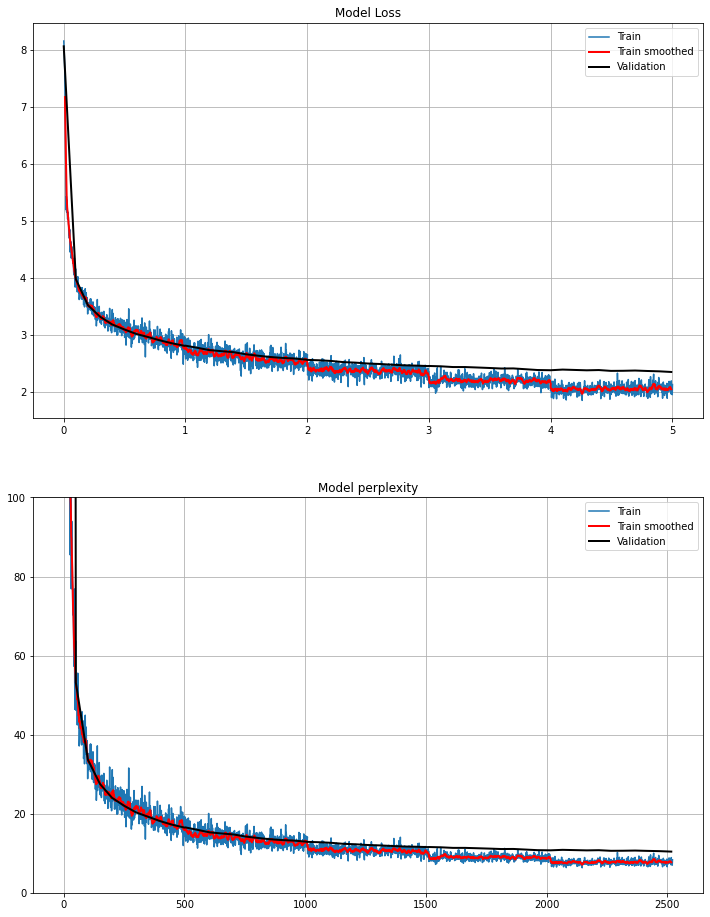

In [98]:
log_data_val = complile_training_loss('Q3_data/jupyter_redo/log_data.txt', validate = True)
log_data_full = complile_training_loss('Q3_data/jupyter_redo/log_data_training.txt')


# Combining log_data.txt and log_data_training.txt into two plots of loss and perplexity
# Training loss and perplexity is additonally smoothed with a 10 point moving average (and displayed separately)

fig, axs = plt.subplots(2, 1)
fig.set_size_inches(12, 16)

EPOCH_LEN = 504  # This can be improved such that epoch_len is infered from log data.

axs[0].plot(log_data_full['net step']/EPOCH_LEN, log_data_full['train loss'], label="Train")
axs[0].plot(log_data_full['net step'][5:-5]/EPOCH_LEN, movingaverage(log_data_full['train loss'], 10)[5:-5],
            label="Train smoothed",
            linewidth=2, color="red",)
axs[0].plot(log_data_val['net step']/EPOCH_LEN, log_data_val['val loss'], label="Validation",
           linewidth=2, color="black")
axs[0].set_title("Model Loss")
axs[0].legend(loc="upper right")
axs[0].grid()

axs[1].plot(log_data_full['net step'], log_data_full['train perplexity'], label="Train")
axs[1].plot(log_data_full['net step'][5:-5], movingaverage(log_data_full['train perplexity'], 10)[5:-5],
            label="Train smoothed",
            linewidth=2, color="red",)
axs[1].plot(log_data_val['net step'], log_data_val['val perplexity'], label="Validation",
            linewidth=2, color="black")
axs[1].set_title("Model perplexity")
axs[1].legend(loc="upper right")
axs[1].set_ylim(0, 100)
axs[1].grid()

plt.show()

## Sample captions generated from test set and BLEU scores

Loaded split ids
-----------------------------------------------------------------------
Predicting image: 3351667632_00f586a30c.jpg


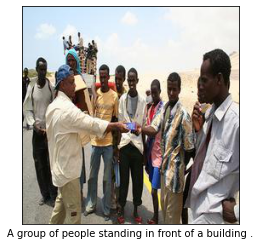

Generated Caption:
A group of people standing in front of a building
-----------------
Reference Captions:
A group of men are standing on a desert road whilst one man hands a blue box to another
A man handing a box to a group of men
A man is handing a box to another man in a group
A man wearing a backwards blue cap hands something to one man in a line of men
Older black man handing small blue object to group of younger black men , outdoors
-----------------
Corpus BLEU score (smoothed): 0.1530


-----------------------------------------------------------------------


Predicting image: 2766291711_4e13a2b594.jpg


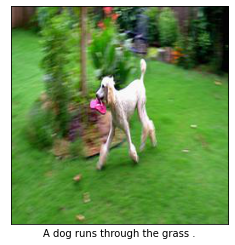

Generated Caption:
A dog runs through the grass
-----------------
Reference Captions:
A dog is running away with a sandal in its mouth
A large white poodle is walking on the grass carrying a sandal
a large white puddle running along with a pink flip flop in its mouth
A white dog carries a pink flip-flop through the green yard
Large white poodle carrying a pink flip flop outside
-----------------
Corpus BLEU score (smoothed): 0.0975


-----------------------------------------------------------------------


Predicting image: 3351111378_b5d80783a1.jpg


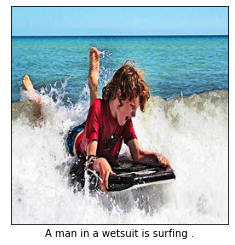

Generated Caption:
A man in a wetsuit is surfing
-----------------
Reference Captions:
A boy on a black surfboard riding the wave on his stomach
A child in a red shirt is using a black wakeboard to splash over a beach wave
A kid with read hair boy boarding in the ocean
A young boy with a red shirt surfing on a black surfboard
A young child wearing a red t-shirt rides a surfboard over a wave
-----------------
Corpus BLEU score (smoothed): 0.0671


-----------------------------------------------------------------------


Predicting image: 3271495320_bca47795fb.jpg


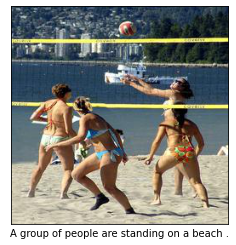

Generated Caption:
A group of people are standing on a beach
-----------------
Reference Captions:
A group of women wearing bikinis are playing beach volleyball
Four women competing in beach volleyball beside a large body of water
Four young women wearing bikinis are playing beach volleyball
Girls in bikinis playing volleyball on the beach
Women in bikinis play beach volleyball by the waterside
-----------------
Corpus BLEU score (smoothed): 0.1786


-----------------------------------------------------------------------


Predicting image: 2467821766_0510c9a2d1.jpg


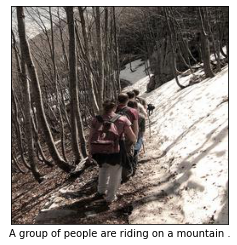

Generated Caption:
A group of people are riding on a mountain
-----------------
Reference Captions:
A group of four hiking through a snowy forest
A group of people are backpacking through the woods and snow
A group of people hike through a snowy wooded area
Four hikers hike on trail through snow
People walking in a line with backpacks are using a trail through the trees
-----------------
Corpus BLEU score (smoothed): 0.4855


-----------------------------------------------------------------------


Predicting image: 424307754_1e2f44d265.jpg


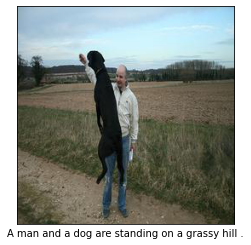

Generated Caption:
A man and a dog are standing on a grassy hill
-----------------
Reference Captions:
A black dog jumps into the air to get a treat from its owner
A black dog jumps up to a man 's uplifted hand
A man demonstrating how high his black dog can jump
Man in field with a black dog jumping at his raised arm
The man is standing next to a dog , while the dog jumps in the air
-----------------
Corpus BLEU score (smoothed): 0.0776


-----------------------------------------------------------------------


Predicting image: 970641406_9a20ee636a.jpg


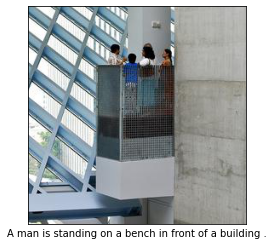

Generated Caption:
A man is standing on a bench in front of a building
-----------------
Reference Captions:
A group of people gather on a balcony
A group of people standing on a balcony in a very modern setting
a group of people standing on a small balcony of a large building
A group of people stand on a balcony
Four people ride in an outdoor elevator
-----------------
Corpus BLEU score (smoothed): 0.1377


-----------------------------------------------------------------------


Predicting image: 3601843201_4809e66909.jpg


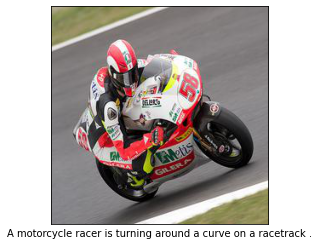

Generated Caption:
A motorcycle racer is turning around a curve on a racetrack
-----------------
Reference Captions:
A man racing on a motorbike
A motorcycle rider drives fast around a curve on a track
A person wearing a red and white uniform is racing a motorcycle with the number 58 on it
A red and white motorcycle is being ridden around a bend on a racetrack
Red and white motorbike number 58 races around the track
-----------------
Corpus BLEU score (smoothed): 0.4833


-----------------------------------------------------------------------


Predicting image: 397725001_e51f7c391c.jpg


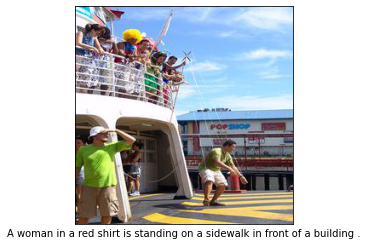

Generated Caption:
A woman in a red shirt is standing on a sidewalk in front of a building
-----------------
Reference Captions:
A man attached to strings is watched by a crowd
A man stands below a crowd
People on a cruise ship deck , and overlooking the deck
People stand on the balcony and deck of a boat
The people on the balcony are controlling the man in the white shorts like a puppet
-----------------
Corpus BLEU score (smoothed): 0.0570


-----------------------------------------------------------------------


Predicting image: 3658733605_fbcf570843.jpg


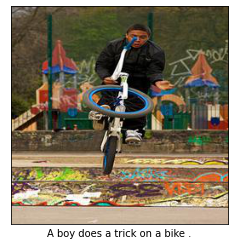

Generated Caption:
A boy does a trick on a bike
-----------------
Reference Captions:
A bicyclist performing a trick over a heavily graffitied wall
a biker performs a trick in the air
A boy on a bike jumping
A cyclist performing a jump on a bicycle
A man in black is on a blue trimmed bicycle in front of a playground
-----------------
Corpus BLEU score (smoothed): 0.2426


-----------------------------------------------------------------------




In [113]:
def test():

    # Test paramaters (these have been taken from the ArgumentParser, which was threw errors in a JupyerNotebook)

    model_path='Q3_data/jupyter_test/'                   # path for saving trained models
    crop_size = 224                                      # size for randomly cropping images
    vocab_path ='Q3_data/flickr_data/vocab.pkl'          # path for vocabulary wrapper
    image_dir ='Q3_data/flickr_data/resized'             # directory for resized image
    caption_path ='Q3_data/flickr_data/annotations.pkl'  # path for train annotation json file
    log_step=50                                          # step size for prining log info
    save_step=100                                        # step size for saving trained models

    # Model parameters
    embed_size=256                                       # dimension of word embedding vectors
    hidden_size=512                                      # dimension of lstm hidden states
    num_layers=1                                         # number of layers in lstm
    num_epochs=5
    batch_size=64
    num_workers=2
    learning_rate=0.001
    vocab_len = 3445                                     # Note: this can be improved such that it is infered from the vocab
    
    transform = transforms.Compose([
        transforms.RandomCrop(crop_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    # Restarting the models
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    # Load vocabulary wrapper
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)

    # Loading datasets (this will automatically use the previously saved split indices to ensure testset purity)
    data_loaders, datasets = get_loader(image_dir, caption_path, vocab,
                                        transform, batch_size,
                                        shuffle=True, num_workers=1)
    train_data_loader, val_data_loader, test_data_loader = data_loaders
    train, val, test = datasets


    # Regeneraating the encoder-decoder model and loading checkpoints
    encoder = EncoderCNN(embed_size).to(device)
    decoder = DecoderRNN(embed_size, hidden_size, vocab_len, 1).to(device)
    encoder_path = 'Q3_data/jupyter_test/encoder-5-504.ckpt'
    decoder_path = 'Q3_data/jupyter_test/decoder-5-504.ckpt'
    
    if os.path.exists(encoder_path) and os.path.exists(decoder_path):
        encoder_checkpoint = torch.load(encoder_path)
        decoder_checkpoint = torch.load(decoder_path)
        encoder.load_state_dict(encoder_checkpoint)
        decoder.load_state_dict(decoder_checkpoint)

    # Moving model to evaluation mode
    encoder.eval()
    decoder.eval()
        
    # Inverting the test dataset to use img id as key and captions as values
    test_image_dict = {}
    for test_image in test.dataset.captions:
        if test_image['image_id'] in test_image_dict:
            test_image_dict[test_image['image_id']].append(test_image['caption'])
        else:
            test_image_dict[test_image['image_id']] = [test_image['caption']]
    
    
    # Selecting 10 random images
    sample_images = 10
    unique_test_images = list(test_image_dict.keys())
    test_image_id = random.sample(range(0, len(unique_test_images)), sample_images)
    
    # Test loop
    print("-----------------------------------------------------------------------")
    for i in range(sample_images):
        
        image_dir = unique_test_images[test_image_id[i]]
        image = Image.open('Q3_data/flickr_data/resized/' + image_dir).convert('RGB')
        

        # Processing image
        img = mpimg.imread('Q3_data/flickr_data/resized/' + image_dir)
        image = transform(image)
        image = torch.unsqueeze(image, 0)
        image = image.to(device)

        # Generating caption tokens
        features = encoder(image)
        outputs = decoder.sample(features)
        output_caption = np.vectorize(vocab.idx2word.get)(outputs.detach().cpu().numpy())[0]

        # Collating caption tokens and tidying up for output
        output_sentance = ""
        for i, word in enumerate(output_caption[1:]):
            if word != "<end>" and word != "<unk>":
                if i == 0:
                    word = str(word).capitalize()
                output_sentance += word
                if word != ".":
                    output_sentance += " "
            elif word == "<end>":
                break
        hypothesis = output_sentance.strip(" .").strip(".").split(" ")

        # Collating refence captions
        reference_captions = test_image_dict[image_dir]
        reference_list = []
        for reference_caption in reference_captions:
            reference_list.append(reference_caption.strip(" .").strip(".").split(" "))

        # Calculating BLUE Corpus values with smoothing function
        smoothie = SmoothingFunction().method4
        bleu_corp = nltk.translate.bleu_score.corpus_bleu([reference_list], [hypothesis], smoothing_function=smoothie)
        
        
        
        # Output info for individual image:
        
        print("Predicting image: {}".format(image_dir))
        
        # Plotting image
        fig, ax = plt.subplots(nrows=1, ncols=1)
        plt.imshow(img)
        ax.set_xlabel(output_sentance)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.show()
        
        print("Generated Caption:")
        print(" ".join(hypothesis))
        print("-----------------")
        print("Reference Captions:")
        for reference in reference_list:
            print(" ".join(reference))
        print("-----------------")
        print("Corpus BLEU score (smoothed): {0:.4f}".format(bleu_corp))
        print("\n\n-----------------------------------------------------------------------\n\n")



test()